# Introduction and Aim
The presence of imbalanced data can have a detrimental impact on the quality of the predictions produced by machine learning classifiers. It is often the case that the target class, which is of greatest interest is the minority class e.g. determining spam or presence of a virus. The major problem with imbalanced data is that it can cause an unwanted bias in the predictions, which favours the majority class, thus degrading the quality of the prediction.

The aim of this analysis is to assess whether the predictions of the clasifiers  for given data set “survival.csv” contain a bias, due to the imbalance data. Four different classifiers will be used including k-Nearest Neighbour (KNN), Decision Tree, Logistic Regression and Gradient Boosting.
If a bias is present, several tests will be carried out to come up with a strategy to try and improve the quality of classifiers predictions. This strategy will then be applied to a new imbalanced data set.


# Part 1 Assess Bias in Predictions
The section below involve a number of steps for assessing for bias.
- Setting up the data into X and y
- Splitting the data into train and test data
- Running the four classifier models on the data set and 
- The statistics for each model will be printed out including size of sample, accuracy, confusion matrix, balanced accuracy and report 
- Hold out testing and Cross validation will be conducted on each of the models  using balanced accuracy scores and the results will be plotted.
- Assessing whether the imbalanced dataset causes any bias in the predictions using the statistics


### Balanced Accuarcy
The balanced Accuracy score is a metric used to assess the accuracy of an imbalanced dataset. It is obtained by averaging the recall of both the major and minor target classes. Like accuracy it is based on a scale from zero to one.The closer the Balanced Accuracy is to Accuracy the less biased the classifier is (Scikit-learn.org, 2010). 


In [1]:
import pandas as pd
import numpy as np
from graphviz import Source
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier,RandomForestClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,balanced_accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE,ADASYN
import matplotlib.pyplot as plt
from sklearn.metrics import auc,precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [3]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [4]:
y = surv.pop('Survived').values
surv.pop('Class')
ap_features = surv.columns
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [5]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))

Minority class : 0.26


## 1.1 Train Test Split

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

# Obtain the accuracy and balanced accuracy of each classifier
classifier_accuracy =[]
classifier_balanced_accuracy =[]

model_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'Accuracy':[],
              'Balanced Accuracy':[]
              
             }


ho_xv={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              'HO Balanced Accuracy':[],
              'HO Accuracy':[],
              'XV Balanced Accuracy':[],
              'XV Accuracy':[],
              
             }



## 1.2 $k$-NN
L5 is the minority class at ~27%.  
$k$-NN classifier picks up this under-representation and accentuates it,  
predicting just 15% L5. 

In [7]:
kNN = KNeighborsClassifier(n_neighbors=3)
y_pred = kNN.fit(X_train, y_train).predict(X_test)
print(X_train.shape,X_test.shape)
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy:  %0.2f' % accuracy)
classifier_accuracy.append(accuracy)
model_scores['Accuracy'].append(round(accuracy,2))



pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion)) 

(183, 3) (123, 3)
Accuracy:  0.76
Minority class in test set : 0.27
Predicted minority class : 0.15
Confusion matrix:
[[83  7]
 [22 11]]


The confusion matrix for kNN shows the number of times the minority class is predicted correctly is half the number of time that the Majority class is predicted incorrectly. The large number of incorrectly guessed minority classes demonstrates that the classifier is bias towards the majority class.
Of the 27% of minority classes that appear in the dataset it is predicted just over half of that amount.


In [8]:
Counter(y_pred)

Counter({'GE5': 105, 'L5': 18})

In [9]:
Counter(y_test)

Counter({'GE5': 90, 'L5': 33})

In [10]:
report = classification_report(y_test, y_pred, target_names = ['GE5','L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.79      0.92      0.85        90
          L5       0.61      0.33      0.43        33

    accuracy                           0.76       123
   macro avg       0.70      0.63      0.64       123
weighted avg       0.74      0.76      0.74       123



The report for kNN suggests that a bias exists due to a large variance in precision, recall and f1-score between the majority and minority target classes. A large difference is present between the positive an negative classes recall.

In [11]:
bal_acc =balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: %0.2f" % bal_acc)

classifier_balanced_accuracy.append(bal_acc)
model_scores['Balanced Accuracy'].append(round(bal_acc,2))

Balanced Accuracy: 0.63


The Balanced Accuracy is quite a bit smaller than the accuracy for the model which gives further proof of a bias towards the majority class. 

### 1.2.1 $k$-NN Hold Out Testing vs Cross Validation
#### Hold Out

In [12]:
reps = 100
def hold_out(X,y,model,reps=100):
    ho_ba = []
    ho_acc = []
    for i in range(reps):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i)
        y_pred = model.fit(X_train, y_train).predict(X_test)

        # Obtain Balanced Accuracy 
        bal_acc = balanced_accuracy_score(y_test, y_pred)
        ho_ba.append(bal_acc)

        # Obtain Accuracy
        acc = accuracy_score(y_test, y_pred)
        ho_acc.append(acc)
        
    return ho_ba,ho_acc

In [13]:
knn_ho_ba, knn_ho_acc = hold_out(X,y,kNN)
ho_xv['HO Balanced Accuracy'].append(sum(knn_ho_ba)/reps)
ho_xv['HO Accuracy'].append(sum(knn_ho_acc)/reps)


#### Cross Validation

In [14]:
def cross_val(X,y,model,reps=100):
    xv_ba = []
    xv_acc =[]
    for i in range(reps):
        scores = cross_val_score(model, X, y, cv=10,scoring='balanced_accuracy')
        xv_ba.append(scores.mean())

        acc = cross_val_score(model, X, y, cv=10,scoring='accuracy')
        xv_acc.append(acc.mean())
        
    return xv_ba,xv_acc

In [15]:
knn_xv_ba, knn_xv_acc = cross_val(X,y,kNN)

ho_xv['XV Balanced Accuracy'].append(sum(knn_xv_ba)/reps)
ho_xv['XV Accuracy'].append(sum(knn_xv_acc)/reps)

Text(0.5, 1.0, 'Balanced Accuracy: Hold Out and X Val')

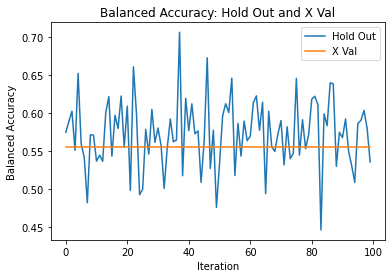

In [16]:
res = pd.DataFrame(knn_ho_ba, columns = ['Hold Out'])
res['X Val']=knn_xv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out and X Val")

In [17]:
print("Mean Hold Out Accuracy: %0.2f "% (sum(knn_ho_acc)/reps))
print("Mean Hold Out Balanced Accuracy: %0.2f "% (sum(knn_ho_ba)/reps))
print("---------------------------------------------")
print("Mean Cross Validation  Accuracy: %0.2f "% (sum(knn_xv_acc)/reps))
print("Mean Cross Validation Balanced Accuracy: %0.2f "% (sum(knn_xv_ba)/reps))

Mean Hold Out Accuracy: 0.70 
Mean Hold Out Balanced Accuracy: 0.57 
---------------------------------------------
Mean Cross Validation  Accuracy: 0.67 
Mean Cross Validation Balanced Accuracy: 0.56 


When comparing the mean Cross Validation and Hold Out results the accuracy and balanced accuracy is worse than the standalone kNN classifier. This would suggest that both methods do not reduce the bias towards the majority class.

## 1.3 Decision Trees

In [18]:
tree = DecisionTreeClassifier(criterion='entropy',max_depth=3)
ap_tree = tree.fit(X, y)

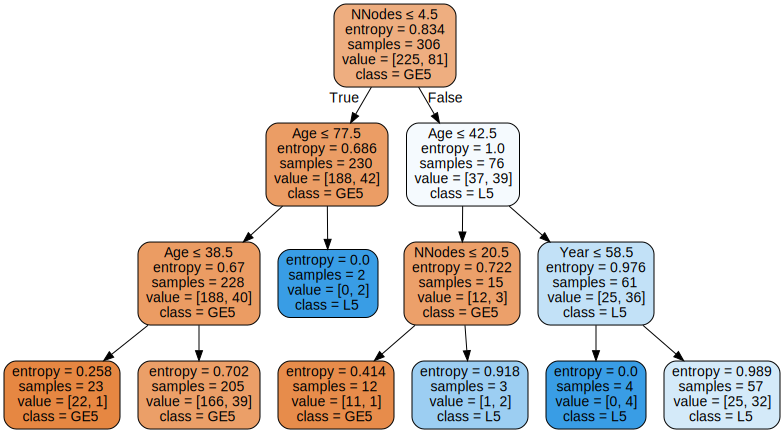

In [19]:
# Use BOTH 'conda install graphviz' and 'pip install graphviz'
tree_ap = export_graphviz(ap_tree, out_file=None, 
                      feature_names=ap_features,
                      class_names=['GE5','L5'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = Source(tree_ap)  
graph

### 1.3.1 Train test Decisison tree

In [20]:
y_pred = tree.fit(X_train, y_train).predict(X_test)

print(X_train.shape,X_test.shape)
dt_accuracy = accuracy_score(y_pred, y_test)
print('Accuracy:  %0.2f' % dt_accuracy)
classifier_accuracy.append(dt_accuracy)
model_scores['Accuracy'].append(round(dt_accuracy,2))


pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion)) 

(183, 3) (123, 3)
Accuracy:  0.72
Minority class in test set : 0.27
Predicted minority class : 0.05
Confusion matrix:
[[86  4]
 [31  2]]


The confusion matrix paints a very strong picture of classifier bias towards the majority class. The number of times the majority class is correctly predicted is half the number of times it is correctly predicted.
The large number for False Negative suggests that there is a clear bias towards the majority class.


In [21]:
report = classification_report(y_test, y_pred, target_names = ['GE5','L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.74      0.96      0.83        90
          L5       0.33      0.06      0.10        33

    accuracy                           0.72       123
   macro avg       0.53      0.51      0.47       123
weighted avg       0.63      0.72      0.64       123



The report for Decision Tree suggests that a bias exists due to a large variance in precision, recall and f1-score between the majority and minority target classes. The very high recall for the Negative class and very low recall for the positive class suggest that the model will nearly always predict a negative class over a positive class.

In [22]:
dt_bal_acc =balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: %0.2f" % bal_acc)

classifier_balanced_accuracy.append(dt_bal_acc)
model_scores['Balanced Accuracy'].append(round(dt_bal_acc,2))

Balanced Accuracy: 0.63


The Balanced Accuracy is quite a bit smaller than the accuracy for the model which gives further proof of a bias towards the majority class. 

###  1.3.2 Decision Tree Hold Out Testing vs Cross Validation
#### Hold Out

In [23]:
dt_ho_ba, dt_ho_acc = hold_out(X,y,tree)

ho_xv['HO Balanced Accuracy'].append(sum(dt_ho_ba)/reps)
ho_xv['HO Accuracy'].append(sum(dt_ho_acc)/reps)

#### Cross Validation

In [24]:
dt_xv_ba, dt_xv_acc = cross_val(X,y,tree)

ho_xv['XV Balanced Accuracy'].append(sum(dt_xv_ba)/reps)
ho_xv['XV Accuracy'].append(sum(dt_xv_acc)/reps)


Text(0.5, 1.0, 'Balanced Accuracy: Hold Out and X Val')

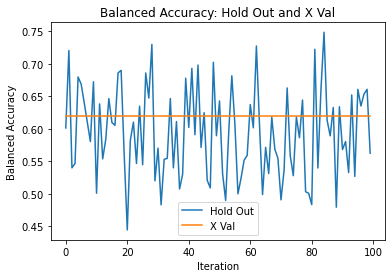

In [25]:
res = pd.DataFrame(dt_ho_ba, columns = ['Hold Out'])
res['X Val']=dt_xv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out and X Val")

In [26]:
print("Mean Hold Out Accuracy: %0.2f "% (sum(dt_ho_acc)/reps))
print("Mean Hold Out Balanced Accuracy: %0.2f "% (sum(dt_ho_ba)/reps))
print("---------------------------------------------")
print("Mean Cross Validation  Accuracy: %0.2f "% (sum(dt_xv_acc)/reps))
print("Mean Cross Validation Balanced Accuracy: %0.2f "% (sum(dt_xv_ba)/reps))

Mean Hold Out Accuracy: 0.72 
Mean Hold Out Balanced Accuracy: 0.59 
---------------------------------------------
Mean Cross Validation  Accuracy: 0.74 
Mean Cross Validation Balanced Accuracy: 0.62 


When comparing the mean Cross Validation and Hold Out results the accuracy and balanced accuracy is better than the standalone Decision tree classifier. The results of these methods suggest that they provide a reduction in bias towards the majority class for the Decision tree classifier.

## 1.4 Logistic Regression

In [27]:
logistic_reg = LogisticRegression(max_iter=4000)
y_pred = logistic_reg.fit(X_train, y_train).predict(X_test)

print(X_train.shape,X_test.shape)
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy:  %0.2f' % accuracy)
classifier_accuracy.append(accuracy)
model_scores['Accuracy'].append(round(accuracy,2))

pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion)) 

(183, 3) (123, 3)
Accuracy:  0.74
Minority class in test set : 0.27
Predicted minority class : 0.07
Confusion matrix:
[[86  4]
 [28  5]]


The Confusion Matrix for Logistic Regression is very similar to that of the Decision Tree classifier, with a very small number of predictions for the minority class and a large number of incorrectly predicted majority classes.

In [28]:
report = classification_report(y_test, y_pred, target_names = ['GE5','L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.75      0.96      0.84        90
          L5       0.56      0.15      0.24        33

    accuracy                           0.74       123
   macro avg       0.65      0.55      0.54       123
weighted avg       0.70      0.74      0.68       123



The report for Logistic Regression suggests that a bias exists due to a large variance in precision, recall and f1-score between the majority and minority target classes. The Positive class recall is very small in comparison to the negative class recall. 

In [29]:
bal_acc =balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: %0.2f" % bal_acc)

classifier_balanced_accuracy.append(bal_acc)
model_scores['Balanced Accuracy'].append(round(bal_acc,2))

Balanced Accuracy: 0.55


The Balanced Accuracy is a lot smaller than the accuracy for the model which gives further proof of a bias towards the majority class. 

### 1.4.1 Logistic Regression Hold Out Testing vs Cross Validation
#### Hold Out

In [30]:
lr_ho_ba, lr_ho_acc = hold_out(X,y,logistic_reg)

ho_xv['HO Balanced Accuracy'].append(sum(lr_ho_ba)/reps)
ho_xv['HO Accuracy'].append(sum(lr_ho_acc)/reps)

#### Cross Validation

In [31]:
lr_xv_ba, lr_xv_acc = cross_val(X,y,logistic_reg)

ho_xv['XV Balanced Accuracy'].append(sum(lr_xv_ba)/reps)
ho_xv['XV Accuracy'].append(sum(lr_xv_acc)/reps)

Text(0.5, 1.0, ' Balanced Accuracy: Hold Out and X Val')

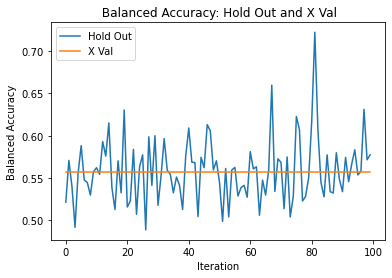

In [32]:
res = pd.DataFrame(lr_ho_ba, columns = ['Hold Out'])
res['X Val']=lr_xv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title(" Balanced Accuracy: Hold Out and X Val")

In [33]:
print("Mean Hold Out Accuracy: %0.2f "% (sum(lr_ho_acc)/reps))
print("Mean Hold Out Balanced Accuracy: %0.2f "% (sum(lr_ho_ba)/reps))
print("---------------------------------------------")
print("Mean Cross Validation  Accuracy: %0.2f "% (sum(lr_xv_acc)/reps))
print("Mean Cross Validation Balanced Accuracy: %0.2f "% (sum(lr_xv_ba)/reps))

Mean Hold Out Accuracy: 0.74 
Mean Hold Out Balanced Accuracy: 0.56 
---------------------------------------------
Mean Cross Validation  Accuracy: 0.75 
Mean Cross Validation Balanced Accuracy: 0.56 


When comparing the mean Cross Validation and Hold Out results the accuracy and balanced accuracy is worse than the standalone Logistic Regression classifier.This would suggest that both methods do not reduce the bias towards the majority class.

## 1.5 Gradient Boosting

In [34]:
grad_boost = GradientBoostingClassifier(max_depth=5)
y_pred = grad_boost.fit(X_train, y_train).predict(X_test)

print(X_train.shape,X_test.shape)
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy:  %0.2f' % accuracy)
classifier_accuracy.append(accuracy)
model_scores['Accuracy'].append(round(accuracy,2))


pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}".format(confusion)) 

(183, 3) (123, 3)
Accuracy:  0.68
Minority class in test set : 0.27
Predicted minority class : 0.18
Confusion matrix:
[[76 14]
 [25  8]]


The Gradient Boosting classifier predicts the minority class the most of all the four models but gueses it incorrectly almost  twice the amount of times it guesses it corrrectly. The model still shows bias toward the majority class with the large number of False Negative predictions.

In [35]:
report = classification_report(y_test, y_pred, target_names = ['GE5','L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.75      0.84      0.80        90
          L5       0.36      0.24      0.29        33

    accuracy                           0.68       123
   macro avg       0.56      0.54      0.54       123
weighted avg       0.65      0.68      0.66       123



The report for Gradient Boosting suggests that a bias exists due to a large variance in precision, recall and f1-score between the majority and minority target classes.  The precision and recall of the positive class are a lot poorer than that of the Negative class suggesting that the model shows a bias towards the majority class when predicting.

In [36]:
bal_acc =balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy: %0.2f" % bal_acc)

classifier_balanced_accuracy.append(bal_acc)
model_scores['Balanced Accuracy'].append(round(bal_acc,2))

Balanced Accuracy: 0.54


The Balanced Accuracy is quite a bit smaller than the accuracy for the model which gives further proof of a bias towards the majority class. 

### 1.5.1 Gradient Boosting Tree Hold Out Testing vs Cross Validation
### Hold Out

In [37]:
gb_ho_ba, gb_ho_acc = hold_out(X,y,grad_boost,reps)

ho_xv['HO Balanced Accuracy'].append(sum(gb_ho_ba)/reps)
ho_xv['HO Accuracy'].append(sum(gb_ho_acc)/reps)


### Cross Validation

In [38]:
gb_xv_ba, gb_xv_acc = cross_val(X,y,grad_boost,reps)

ho_xv['XV Balanced Accuracy'].append(sum(gb_xv_ba)/reps)
ho_xv['XV Accuracy'].append(sum(gb_xv_acc)/reps)


Text(0.5, 1.0, 'Balanced Accuracy: Hold Out and X Val')

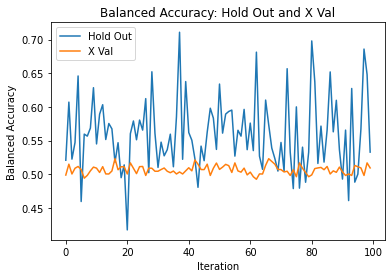

In [39]:
res = pd.DataFrame(gb_ho_ba, columns = ['Hold Out'])
res['X Val']=gb_xv_ba
%matplotlib inline
ax = res.plot()
ax.set_xlabel("Iteration")
ax.set_ylabel("Balanced Accuracy")
ax.set_title("Balanced Accuracy: Hold Out and X Val")

In [40]:
print("Mean Hold Out Accuracy: %0.2f "% (sum(gb_ho_acc)/reps))
print("Mean Hold Out Balanced Accuracy: %0.2f "% (sum(gb_ho_ba)/reps))
print("---------------------------------------------")
print("Mean Cross Validation  Accuracy: %0.2f "% (sum(gb_xv_acc)/reps))
print("Mean Cross Validation Balanced Accuracy: %0.2f "% (sum(gb_xv_ba)/reps))

Mean Hold Out Accuracy: 0.67 
Mean Hold Out Balanced Accuracy: 0.56 
---------------------------------------------
Mean Cross Validation  Accuracy: 0.62 
Mean Cross Validation Balanced Accuracy: 0.51 


The Hold out Strategy leads to a marginal improvement in accuracy and balanced accuracy. while the Cross Validation method leads to an improvement in accuracy and a fall in balanced accuracy. The Hold Out method appears to be a good solution to reducing the bias towards the majority class for the Gradient Boosting classifier.

In [41]:
def grouped_plot(labels,f1,f2,title="",label1="",label2="",x_label="",y_label="",size=None):
    
    if size:
        plt.rcParams["figure.figsize"] = size
    
    else:
        plt.rcParams["figure.figsize"] = (10,7)

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, f1, width, label=label1)
    rects2 = ax.bar(x + width/2, f2, width, label=label2)
        

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()
    ax.legend( bbox_to_anchor=(1.05, 1), loc='upper left')
   

    fig.tight_layout()

    plt.show()



In [42]:
# Display dictionaries as dataframes
ho_xv_df = pd.DataFrame.from_dict(ho_xv)
model_scores_df = pd.DataFrame.from_dict(model_scores)
acc_df = pd.concat([model_scores_df,ho_xv_df], axis=1)
acc_df = acc_df.loc[:,~acc_df.columns.duplicated()]

## 1.6 Evaluation of Models

### 1.6.1 Evaluation of Models skills using Roc and AUC
Further evaluation will be conducted to assess how skillful the four models are at predicting the true positive class and identify when the model predicts the false positive class.  This evaluation will be carried out by using a ROC curve and identifying the percentage of the graph that it is below this curve referred to as the Area under the ROC curve. The benefits of obtaining the AUC is that it allows for a comparison between all four models that use different distributions and scales. The ROC evaluates the clasisification performance of the model at different thresholds.The hope is that the true positives should outnumber the false positives. In the following example a threshold of 0.5 is used which would be similar to the model randomly classifying each value (Sarang Narkhede, 2018).


The area under the Curve (AUC) is a metric used to provide a single score for the skilfulness of a classifier at predicting the true positive outcome. The closer the AUC is to 1 the more skilful while the closer the AUC is to 0 the poorer the classifier is.The ROC is a useful evaluation tool for dealing with both balanced and imbalanced datasets as no bias is shown towards either the majority of minority classes (Brownlee, 2020b).


In [43]:
# The following code has been adapted from: https://github.com/dataprofessor/code/blob/master/python/ROC_curve.ipynb
#obtain the prediction pobabilities calulated by the Random Forrest, logistic regression and linear regression

y_test_binary = np.unique(y_test, return_inverse=True)[1]
y_test_binary

# set up a random probability case where the threshold will be 0.5
r_probs = [0 for _ in range(len(y_test_binary))]

# Find the probabilities from the three models
kNN_probs = kNN.predict_proba(X_test)
tree_probs = tree.predict_proba(X_test)
logreg_probs = logistic_reg.predict_proba(X_test)
gb_probs = grad_boost.predict_proba(X_test)

# Select only the first colum in the probability arrays
kNN_probs = kNN_probs[:, 1]
tree_probs =tree_probs[:, 1]
logreg_probs = logreg_probs[:, 1]
gb_probs = gb_probs[:, 1]

# Find the Area under the ROC curve by comparing the probabilities against the actual outcome
r_auc = roc_auc_score(y_test, r_probs)
kNN_auc = roc_auc_score(y_test,kNN_probs)
tree_auc = roc_auc_score(y_test,tree_probs)
logreg_auc = roc_auc_score(y_test,logreg_probs)
gb_auc = roc_auc_score(y_test,gb_probs)


# Print the Area under the ROC Curve
print('Random (chance) Prediction: AUROC = %.2f' % (r_auc))
print('kNN: AUROC = %.2f' % (kNN_auc))
print('Decision Tree: AUROC = %.2f' % (tree_auc))
print('Logistic Regression: AUROC = %.2f' % (logreg_auc))
print('Gradient Boosting: AUROC = %.2f' % (gb_auc))


Random (chance) Prediction: AUROC = 0.50
kNN: AUROC = 0.84
Decision Tree: AUROC = 0.75
Logistic Regression: AUROC = 0.68
Gradient Boosting: AUROC = 0.91


In [44]:
# Obtain the false positives and true positives for the random classification
r_fpr, r_tpr, _ = roc_curve(y_test_binary, r_probs)

# Obtain the false positives and true positives for the 3 models
kNN_fpr, kNN_tpr, _ = roc_curve(y_test_binary, kNN_probs)
tree_fpr, tree_tpr, _ = roc_curve(y_test_binary, tree_probs)
logreg_fpr, logreg_tpr, _ = roc_curve(y_test_binary, logreg_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test_binary, gb_probs)

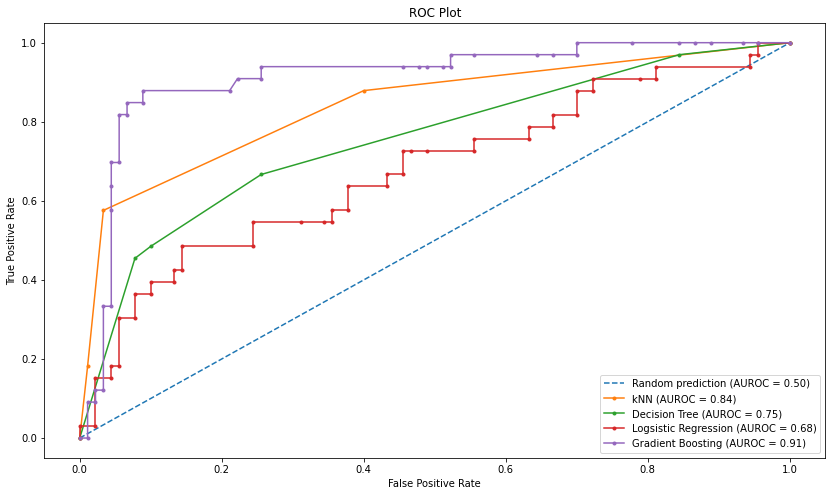

In [45]:
# set size of plot
plt.figure(figsize=(14,8))

#Plot all three ROC curves for the models
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.2f)' % r_auc)
plt.plot(kNN_fpr,kNN_tpr , marker='.', label='kNN (AUROC = %0.2f)' % kNN_auc)
plt.plot(tree_fpr,tree_tpr , marker='.', label='Decision Tree (AUROC = %0.2f)' % tree_auc)
plt.plot(logreg_fpr,logreg_tpr , marker='.', label='Logsistic Regression (AUROC = %0.2f)' % logreg_auc)
plt.plot(gb_fpr,gb_tpr , marker='.', label='Gradient Boosting (AUROC = %0.2f)' % gb_auc)


# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend(loc='lower right') # 
# Show plot
plt.show()

- The ROC plot above shows that each of the four models are better at predicting the true positive rate compared to the random model.

- Gradient Boosting achieved the highest AUC closely followed by kNN, while the Logistic Regression achieved the poorest AUC.

One issue when using ROC is that it can often be deceiving when a small sample of correct or incorrect predictions can cause a skew in the ROC. One approach that may be useful for evaluation this dataset where the number of positive outcomes is significantly lower than negative outcome is Precision-Recall Curves (Brownlee, 2020b).

### 1.6.2 Precision Recall Curve

In [46]:
# The following code adapted from:
#https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

# predict class values
r_precision, r_recall, _ = precision_recall_curve(y_test_binary, r_probs)
logreg_precision, logreg_recall, _ = precision_recall_curve(y_test_binary, logreg_probs)
kNN_precision, kNN_recall, _ = precision_recall_curve(y_test_binary, kNN_probs)
tree_precision, tree_recall, _ = precision_recall_curve(y_test_binary, tree_probs)
gb_precision, gb_recall, _ = precision_recall_curve(y_test_binary, gb_probs)

# Obtain Precision Recall AUC
r_PRAUC = auc(r_recall,r_precision)
log_PRAUC = auc(logreg_recall,logreg_precision)
kNN_PRAUC = auc(kNN_recall,kNN_precision)
tree_PRAUC = auc(tree_recall,tree_precision)
gb_PRAUC = auc(gb_recall,gb_precision)

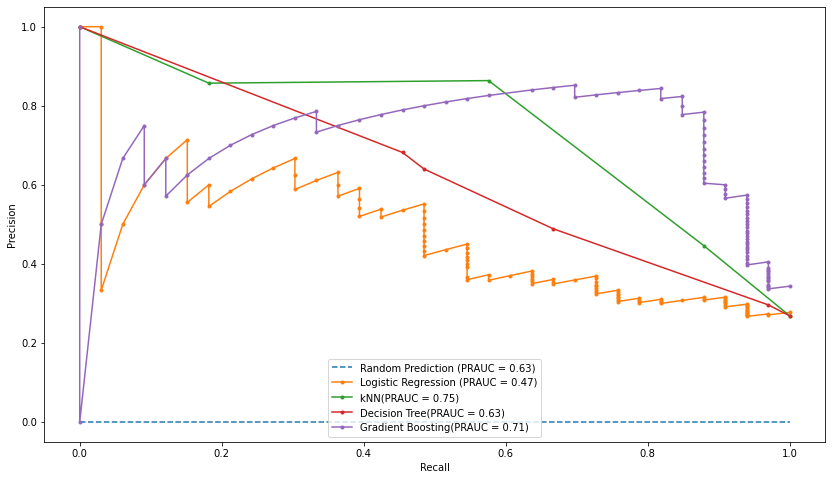

In [47]:
# Plot the precision recall
plt.figure(figsize=(14,8))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='Random Prediction (PRAUC = %0.2f)' % r_PRAUC)
plt.plot(logreg_recall, logreg_precision, marker='.', label='Logistic Regression (PRAUC = %0.2f)' % log_PRAUC)
plt.plot(kNN_recall, kNN_precision, marker='.', label='kNN(PRAUC = %0.2f)' % kNN_PRAUC)
plt.plot(tree_recall, tree_precision, marker='.', label='Decision Tree(PRAUC = %0.2f)' % tree_PRAUC)
plt.plot(gb_recall, gb_precision, marker='.', label='Gradient Boosting(PRAUC = %0.2f)' % gb_PRAUC)
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()

# show the plot
plt.show()

- Like in the ROC Curve the Gradient Boosting achives the Best AUC for the precision and Recall curve.

-  The Logistic Regression AUC is worse than that of the Random prediction.

### 1.6.3 Accuracies and f1-score of all models


In [48]:
model_scores_df

,Model,Accuracy,Balanced Accuracy
0,kNN,0.76,0.63
1,Decision Tree,0.72,0.51
2,Logistic Regression,0.74,0.55
3,Gradient Boosting,0.68,0.54


The table above show that although the accuracies are decent for all four models the balanced accuracies are much lower.

- kNN achieves the highest accuracy and Balanced Accuracy 

- Decision tree scores the worst in terms of Balanced accuracy

- Gradient Boosting scores the worst in terms of accuracy


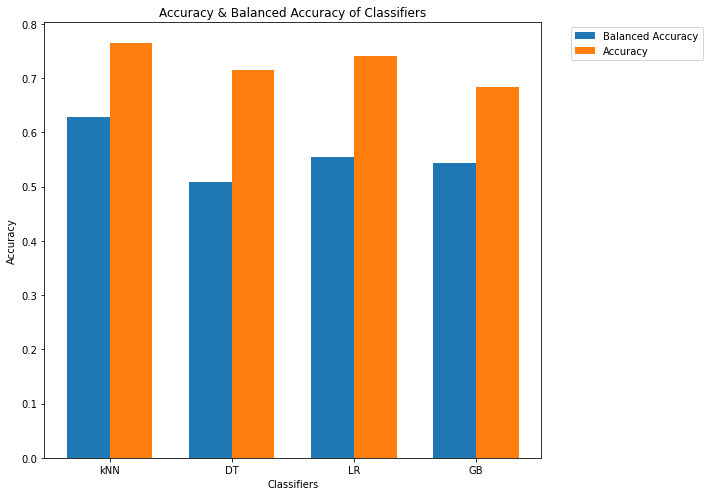

In [49]:
labels = ['kNN','DT','LR','GB']
title="Accuracy & Balanced Accuracy of Classifiers"
label1 ="Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label ="Accuracy"


grouped_plot(labels,classifier_balanced_accuracy,classifier_accuracy,title,label1,label2,x_label,y_label)

The above grouped bar chart clearly demonstrates the gap between the accuracy and the balanced accuracy of all of the classifiers used. In each case the balanced accuracy is significantly lower than accuracy which shows that there is a  bias in the data. The kNN can be clearly seen to have the smallest gap between the Accuracy and Balance Accuracy, both of which are the highest of all the classifiers.

## 1.7 Analysis of Models
Throughout each of the models, it is clear to see that the accuracy is a poor estimator of the quality. A more useful measures for determining the quality of each model is the confusion matrix. The confusion matrix demonstrates that each model is excellent at predicting the negative class, which is also the majority class. This is evident from the True Negatives (TN) being the largest value in the confusion matrix. The models however struggled to predict the True Positive (TP) class, which is the minority class. this poor precision is viewed in the large number false Negative predictions.

This shows that each of the models have a bias for the majority class. When observing the report for the four models the precision, recall and f1 score scores for the positive outcome are significantly worse than the negative outcome. This is also the case for the balanced accuracy. The fact that balanced accuracy is lower than accuracy for all the models further suggests that an imbalance is present.


###  1.7.1 Analysis of Hold out and Cross Validation
The results of the cross-validation and Hold Out graphs are very similar for the four models. Hold Out has a large variance in the balanced accuracy across the board, with very high accuracies and low accuracies occurring frequently throughout. Whereas the cross-validation balanced accuracies appear to be constant for each of the four models. 

The accuracies achieved by each model for both cross-validation and Hold Out remain significantly higher than the balanced accuracy scores this suggests that even with cross-validation and Hold Out technique’s majority bias is still present.

In [50]:
acc_df

,Model,Accuracy,Balanced Accuracy,HO Balanced Accuracy,HO Accuracy,XV Balanced Accuracy,XV Accuracy
0,kNN,0.76,0.63,0.572656,0.701818,0.555446,0.673871
1,Decision Tree,0.72,0.51,0.594204,0.718701,0.619917,0.735699
2,Logistic Regression,0.74,0.55,0.558488,0.741429,0.557331,0.745054
3,Gradient Boosting,0.68,0.54,0.559300,0.666364,0.506445,0.616733


- For kNN both Cross Validation and Hold Out provide poorer accuracy and balanced accuracies.
- For Decision tree both Cross Validation and Hold Out provide better accuracy and balanced accuracies.
- A very small improvement is seen when Logistic regression is used with both Cross Validation and Hold Out.
- For Gradient boosting Hold Out Testing provided an improvement in terms of balanced accuracy and a drop in accuracy. Cross Validation leads to a fall in both accuracy and balance accuracy.

The Decision tree saw the largest improvement in terms of Balanced Accuracy.



## 1.8 Results of Analysis

- The standalone kNN classifier achieved the best overall f1-score for predicting minority class due to its high precision and recall of 56% and 28% respectivley, demonstrating the smallest bias of the classifiers tested. 


- The Standalone Decision Tree classifier achieved the lowest overall accuracy and Balanced accuracy of all the classifiers.


- The standalone Logistic Regression classifier achieved the highest Prescision rate of 67%  but the lowest Recall for predicting minority class.


- The Decision tree saw the most improvement in accuracy/balanced accuracy when used with Cross Validation and Hold Out so it will be used as the sole model in the rectifying of Bias in part 2 below.

# Part 2.  Strategy to Rectify Bias
In order to reduce the impact of the imbalanced data on the quality of the predictions, a number of the tests will be carried out. These tests will be conducted using known methods for dealing with imbalanced data, the method or methods that works best at reducing the bias towards the majority class for the imbalanced data will be used as the strategy for the new datasets. The three methods for dealing with imbalanced data used are **Bagging, Undersampling** and **Oversampling**. A brief synopsis of each method will be provided before each test, followed by analysis of the results.

Each of the methods used in this section will be compared to the accuracy,balanced accuracy,recall,precision,f1-score and AUROC of the classifiers used in section 1 above. 


In [51]:
# Function to display the classifier information 
def classifier_info(X_train, X_test, y_train, y_test,model,target0,target1):

    y_pred = model.fit(X_train, y_train).predict(X_test)

    print(X_train.shape,X_test.shape)
    
    accuracy = round(accuracy_score(y_pred, y_test),2)
    print('Accuracy:  %0.2f' % accuracy)
    bal_acc = round(balanced_accuracy_score(y_test, y_pred),2)
    print("Balanced Accuracy: %0.2f" % bal_acc)
    
    pred_neg = Counter(y_pred)[target1]
    test_neg = Counter(y_test)[target1]

    print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
    print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))
    print("================================================")
    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n{}".format(confusion)) 

    report = classification_report(y_test, y_pred, target_names = [str(target0),str(target1)])
    print("================================================")
    print("Report:\n{}".format(report)) 
    
    print("================================================")
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    print("Balanced Accuracy: %0.2f" % bal_acc)
    
    # Obtain the ROC and AUC
    
    # Change the target features to binary 
    y_test = np.unique(y_test, return_inverse=True)[1]
    
    model_probs= model.predict_proba(X_test)[:, 1]
    model_auc = roc_auc_score(y_test,model_probs )
    
    print(f'{type(model).__name__}: AUROC = %.2f' % (model_auc))
    
    
    
   
    
    return accuracy,bal_acc

## 2.1 Bagging

The Aim of ensemble is to join the predictions of base estimators which are equivalent to a single classifier. The benefits of an ensemble is that it can refine the robustness and generalisation of a single classifier (Scikit-learn.org, 2012).

Bagging is an ensemble that involves creating a subset of the original training set and then predicting using that subset. The predictions from all of the subsets are then aggregate to get a definitive prediction (Scikit-learn.org, 2012).

In [52]:
bag_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'Bagging Accuracy':[],
              'Bagging Bal Acc':[]
              
             }

### 2.1.1 kNN Bagging

In [53]:
kNN_bag_setup = BaggingClassifier(base_estimator=kNN, n_estimators=100,bootstrap=True,random_state=42)

kNN_bag =classifier_info(X_train, X_test,y_train, y_test,kNN_bag_setup,'GE5','L5')


bag_scores['Bagging Accuracy'].append(round(kNN_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(kNN_bag[1],2))

(183, 3) (123, 3)
Accuracy:  0.80
Balanced Accuracy: 0.67
Minority class in test set : 0.27
Predicted minority class : 0.15
Confusion matrix:
[[85  5]
 [20 13]]
Report:
              precision    recall  f1-score   support

         GE5       0.81      0.94      0.87        90
          L5       0.72      0.39      0.51        33

    accuracy                           0.80       123
   macro avg       0.77      0.67      0.69       123
weighted avg       0.79      0.80      0.77       123

Balanced Accuracy: 0.67
BaggingClassifier: AUROC = 0.69


- The accuracy of the kNN classifier when used with Bagging improves from 0.76 to 0.80, While the balanced accuracy improves from 0.63 to 0.67.

- The number of True Positive predictions increases from 11 to 13 While the False Positives falls from 7 to 5. Overall, the percentage of minority class predicted remains at 0.15 of 0.27.

- Precision of the Positive class improves from 0.61 to 0.72

- Recall of the Positive class improves from 0.33 to 0.39

- The precision and Recall of the Negative class also improve.

- The AUROC has fallen from 0.84 to 0.67

- Bagging using kNN appears to be a solution to deal with the bias towards the majority class as it increases the f1-score,accuracy and Balanced accuracy of the kNN classifier.



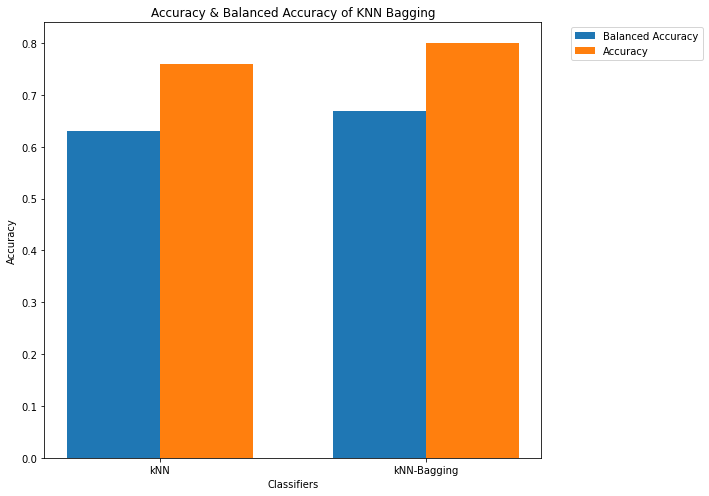

In [54]:
labels = ['kNN','kNN-Bagging',]
title= "Accuracy & Balanced Accuracy of KNN Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_list=[model_scores['Balanced Accuracy'][0],kNN_bag[1]]
kNN_acc_list=[model_scores['Accuracy'][0],kNN_bag[0]]




grouped_plot(labels,kNN_ba_list,kNN_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate the small improvement in both balanced accuracy and accuracy for the kNN classifier.

### 2.1.2 Decision Tree Bagging

In [55]:
dt_bag_setup = BaggingClassifier(base_estimator=tree, n_estimators=100,bootstrap=True,random_state=42)

dt_bag =classifier_info(X_train, X_test,y_train, y_test,dt_bag_setup,'GE5','L5')

bag_scores['Bagging Accuracy'].append(round(dt_bag[0],2))
bag_scores['Bagging Bal Acc'].append(63)

(183, 3) (123, 3)
Accuracy:  0.76
Balanced Accuracy: 0.63
Minority class in test set : 0.27
Predicted minority class : 0.15
Confusion matrix:
[[83  7]
 [22 11]]
Report:
              precision    recall  f1-score   support

         GE5       0.79      0.92      0.85        90
          L5       0.61      0.33      0.43        33

    accuracy                           0.76       123
   macro avg       0.70      0.63      0.64       123
weighted avg       0.74      0.76      0.74       123

Balanced Accuracy: 0.63
BaggingClassifier: AUROC = 0.71


- The Accuracy of the Decision tree classifier when used with bagging improved from 0.72 to 0.76 however the balanced accuracy remains ast 0.63.


- The number of times the minority class was predicted increased from 0.05 to 0.15 


- The True positive predictions increase from 2 to 11 while the number of false positive predictions increased from 4 to 7.


- The precision and recall for the minority class improved from 0.33 to 0.61 and 0.06 to 0.33 respectively.


- The AUROC has fallen from 0.75 to 0.71


- The f1-score of the Positive class has improved from 0.10 to 0.43.


- Although the balanced accuracy did not improve it appears that there is an increase in the amount of times that the Minority class is being predicted. This suggests that it is a suitable approach for dealing with the bias towards the minority class.



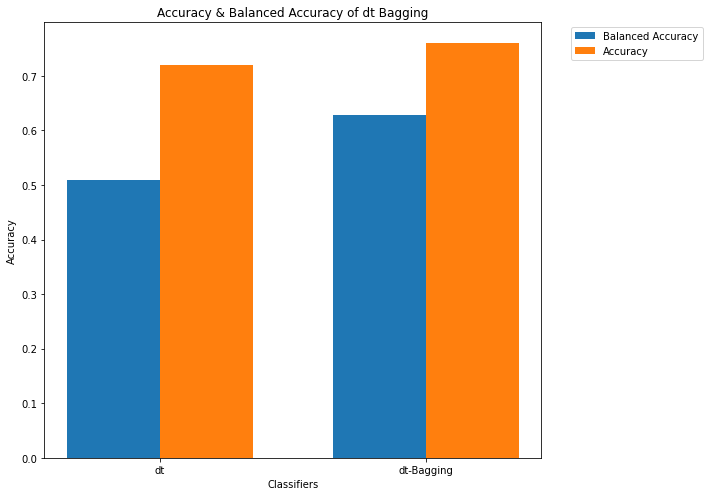

In [56]:
labels = ['dt','dt-Bagging',]
title= "Accuracy & Balanced Accuracy of dt Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_list=[model_scores['Balanced Accuracy'][1],dt_bag[1]]
dt_acc_list=[model_scores['Accuracy'][1],dt_bag[0]]




grouped_plot(labels,dt_ba_list,dt_acc_list,title,label1,label2,x_label,y_label)

The grouped barchart above shows the improvement to accuracy when bagging is used

### 2.1.3 Logistic Regression Bagging

In [57]:
lr_bag_setup = BaggingClassifier(base_estimator=logistic_reg, n_estimators=100,bootstrap=True,random_state=42)

lr_bag =classifier_info(X_train, X_test,y_train, y_test,lr_bag_setup,'GE5','L5')

bag_scores['Bagging Accuracy'].append(round(lr_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(lr_bag[1],2))

(183, 3) (123, 3)
Accuracy:  0.75
Balanced Accuracy: 0.58
Minority class in test set : 0.27
Predicted minority class : 0.10
Confusion matrix:
[[85  5]
 [26  7]]
Report:
              precision    recall  f1-score   support

         GE5       0.77      0.94      0.85        90
          L5       0.58      0.21      0.31        33

    accuracy                           0.75       123
   macro avg       0.67      0.58      0.58       123
weighted avg       0.72      0.75      0.70       123

Balanced Accuracy: 0.58
BaggingClassifier: AUROC = 0.68


- The Accuracy of the model improves from 0.74 to 0.75 while the balanced accuracy increases from 0.55 to 0.58.

- The number of True positives increases from 5 to 7 while the number of False Positives increases from 4 to 5.

- The AUROC has remained the same at 0.68

- The f1 scores for both the minority and majority classes improve.

- The results suggest that Bagging is a suitable approach for dealing with the bias towards the minority class.


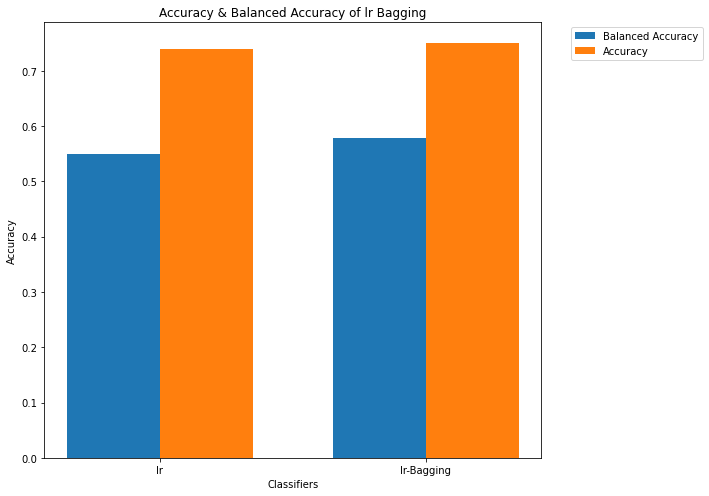

In [58]:
labels = ['lr','lr-Bagging',]
title= "Accuracy & Balanced Accuracy of lr Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_list=[model_scores['Balanced Accuracy'][2],lr_bag[1]]
lr_acc_list=[model_scores['Accuracy'][2],lr_bag[0]]




grouped_plot(labels,lr_ba_list,lr_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate the small improvement in both balanced accuracy and accuracy for the Logistic Regression classifier.

### 2.1.4 Gradient Boosting Bagging

In [59]:
gb_bag_setup = BaggingClassifier(base_estimator=logistic_reg, n_estimators=100,bootstrap=True,random_state=42)

gb_bag =classifier_info(X_train, X_test,y_train, y_test,gb_bag_setup,'GE5','L5')

bag_scores['Bagging Accuracy'].append(round(gb_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(gb_bag[1],2))

(183, 3) (123, 3)
Accuracy:  0.75
Balanced Accuracy: 0.58
Minority class in test set : 0.27
Predicted minority class : 0.10
Confusion matrix:
[[85  5]
 [26  7]]
Report:
              precision    recall  f1-score   support

         GE5       0.77      0.94      0.85        90
          L5       0.58      0.21      0.31        33

    accuracy                           0.75       123
   macro avg       0.67      0.58      0.58       123
weighted avg       0.72      0.75      0.70       123

Balanced Accuracy: 0.58
BaggingClassifier: AUROC = 0.68


 - When used with Bagging The Gradient boosting models sees a vast improvement in accuracy from 0.64 to 0.75 and a minor improvement in balanced accuracy from 0.52 to 0.58.
 
- The number of Negative classes predicted has decreased form 0.19 to 0.10 however the number of False Negative prediction has also reduced. 

- The precision at predicting the negative class has improved from 0.30 to 0.58

- The f1-score for both the negative and positive classes have greatly improved.

- The AUROC has fallen from 0.85 to 0.68

- The Bagging method does not appear to improve the bias towards the majority class with fewer predictions for the minority class but the majority of predictions for the Positive class were incorrect.

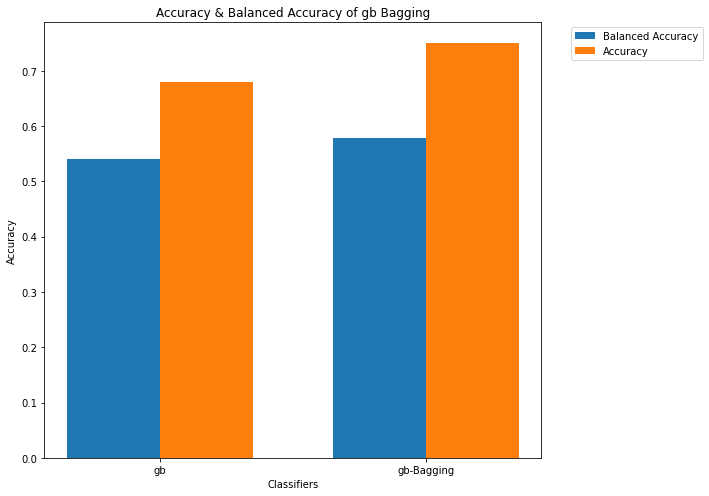

In [60]:
labels = ['gb','gb-Bagging',]
title= "Accuracy & Balanced Accuracy of gb Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_list=[model_scores['Balanced Accuracy'][3],gb_bag[1]]
gb_acc_list=[model_scores['Accuracy'][3],gb_bag[0]]




grouped_plot(labels,gb_ba_list,gb_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate the small improvement in balanced accuracy and large improvemnt in  accuracy for the Gradient Boost classifier.

In [61]:
bag_scores_df = pd.DataFrame.from_dict(bag_scores)
bag_scores_df

,Model,Bagging Accuracy,Bagging Bal Acc
0,kNN,0.80,0.67
1,Decision Tree,0.76,63.00
2,Logistic Regression,0.75,0.58
3,Gradient Boosting,0.75,0.58


In [62]:
# Dsplay the accuracy and balanced accuracy
bag_scores_df = pd.DataFrame.from_dict(bag_scores)
bag_ba_ac = pd.concat([model_scores_df,bag_scores_df], axis=1)
bag_ba_ac = bag_ba_ac.loc[:,~bag_ba_ac.columns.duplicated()]


bag_ba_ac['Diff ACC'] = bag_ba_ac['Bagging Accuracy'] -bag_ba_ac['Accuracy']
bag_ba_ac['Diff BA'] = bag_ba_ac['Bagging Bal Acc'] - bag_ba_ac['Balanced Accuracy']

cols = bag_ba_ac.columns.tolist()
cols
cols=['Model',
 'Accuracy',
 'Bagging Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'Bagging Bal Acc',
 'Diff BA']


bag_ba_ac = bag_ba_ac[cols]
bag_ba_ac


,Model,Accuracy,Bagging Accuracy,Diff ACC,Balanced Accuracy,Bagging Bal Acc,Diff BA
0,kNN,0.76,0.80,0.04,0.63,0.67,0.04
1,Decision Tree,0.72,0.76,0.04,0.51,63.00,62.49
2,Logistic Regression,0.74,0.75,0.01,0.55,0.58,0.03
3,Gradient Boosting,0.68,0.75,0.07,0.54,0.58,0.04


- For all of the models a slight improvement to accuracy is seen when applying Bagging.

- For all of the models a slight improvement to Balanced accuracy is seen when applying Bagging, with a large growth for the Decision tree.

### 2.1.5 Evaluation of Bagging
Overall Bagging appears to have a positive impact on the f1-scores, accuracy and balanced accuracy of the models. The number of times the minority class was guessed varied depending on the classifier used. The Decision tree classifier saw the largest improvement of all the classifiers in terms of balanced accuracy.


## 2.2 Undersampling
Undersampling is a method for balancing target classes on a dataset with imbalanced data.It works on the majority class by removing of data in order to reduce the skewed distribution. There are a number of Undersampling techniques that remove examples based on weight, distance and randomness (Brownlee, 2020).


### 2.2.1 Near Miss
Near Miss is an prototype selection technique  that chooses data based on distance between the majority and minority classes, based on kNN . It has three versions that impact which samples are selected (Brownlee, 2020).

- Version 1 of the Near miss algorithm involves taking a number of samples from the majority class with the smallest average distance to the K closest occurrences of the minority class (GeeksforGeeks, 2019).


- Version  2 of the Near miss algorithm involves taking a number of samples from the majority class with the largest average distance to the K closest occurrences of the minority class (GeeksforGeeks, 2019).


- Version 3 of the Near miss algorithm involves taking a number of samples of the majority class with the smallest average distance to each instance of the minority class (Brownlee, 2020a).

The training set will be resampled and the same X_test will be used to assess the classifiers.

In [63]:
nm_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'NM Accuracy':[],
              'NM Bal Acc':[]
              
             }

In [64]:
nm1 = NearMiss(version=1,sampling_strategy=0.5)
X_resampled_nm1, y_resampled_nm1 = nm1.fit_resample(X_train, y_train)
print(sorted(Counter(y_resampled_nm1).items()))

[('GE5', 96), ('L5', 48)]


#### 2.2.1.1 kNN Near Miss  

In [65]:
kNN_nm =classifier_info(X_resampled_nm1, X_test,y_resampled_nm1, y_test,tree,'GE5','L5')

nm_scores['NM Accuracy'].append(round(kNN_nm[0],2))
nm_scores['NM Bal Acc'].append(round(kNN_nm[1],2))

(144, 3) (123, 3)
Accuracy:  0.72
Balanced Accuracy: 0.63
Minority class in test set : 0.27
Predicted minority class : 0.26
Confusion matrix:
[[73 17]
 [18 15]]
Report:
              precision    recall  f1-score   support

         GE5       0.80      0.81      0.81        90
          L5       0.47      0.45      0.46        33

    accuracy                           0.72       123
   macro avg       0.64      0.63      0.63       123
weighted avg       0.71      0.72      0.71       123

Balanced Accuracy: 0.63
DecisionTreeClassifier: AUROC = 0.68


- The accuracy using Near miss fell from 0.76 to 0.72 and the Balanced accuracy remains at 0.63

- The number of True postives has increased from 11 to 15

- The number of False negatives has dropped from 22 to 18.

- The minority class precision has fallen from 0.61 to 0.47

- The minority class recall has increased from 0.33 to 0.45

- The AUROC has fallen from 0.84 to 0.68

- The Negative f1 score has fallen while the positive f1score has risen

- Near Miss When used with KNN appears to reduce the bias towards the minority class with a lare increase in predictions of the Positive class but  a greater number of False positives were predicted.



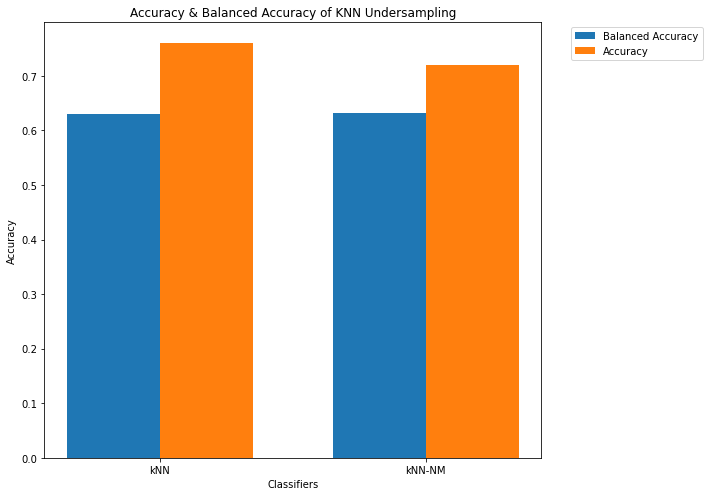

In [66]:
labels = ['kNN','kNN-NM',]
title= "Accuracy & Balanced Accuracy of KNN Undersampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_nm=[model_scores['Balanced Accuracy'][0],kNN_nm[1]]
kNN_acc_nm=[model_scores['Accuracy'][0],kNN_nm[0]]




grouped_plot(labels,kNN_ba_nm,kNN_acc_nm,title,label1,label2,x_label,y_label)

The grouped barchart shows the fall in accuracy and stagnation of balanced accuracy.

#### 2.2.1.2 Decision Tree Near Miss 

In [67]:
dt_nm =classifier_info(X_resampled_nm1, X_test,y_resampled_nm1, y_test,tree,'GE5','L5')

nm_scores['NM Accuracy'].append(round(dt_nm[0],2))
nm_scores['NM Bal Acc'].append(round(dt_nm[1],2))

(144, 3) (123, 3)
Accuracy:  0.72
Balanced Accuracy: 0.63
Minority class in test set : 0.27
Predicted minority class : 0.26
Confusion matrix:
[[73 17]
 [18 15]]
Report:
              precision    recall  f1-score   support

         GE5       0.80      0.81      0.81        90
          L5       0.47      0.45      0.46        33

    accuracy                           0.72       123
   macro avg       0.64      0.63      0.63       123
weighted avg       0.71      0.72      0.71       123

Balanced Accuracy: 0.63
DecisionTreeClassifier: AUROC = 0.68


- both the Accuracy and Balanced Accuracy remain the same at 0.72 and 0.63 respectively.

- The number of True postives has increased from 2 to 15

- The number of False negatives has dropped from 31 to 18.

- The minority class precision has improved from 0.33 to 0.47

- The minority class recall has improved from 0.06 to 0.45

- The AUROC has fallen from 0.75 to 0.68

- The positive f1-score increase from 0.1 to 0.46 and negative f1-scores fell from 0.83 to 0.81.

- Near Miss When used with Decision tree appears to reduce the bias towards the minority class with a large increase in predictions of the Positive class but a greater number of False positives were predicted.


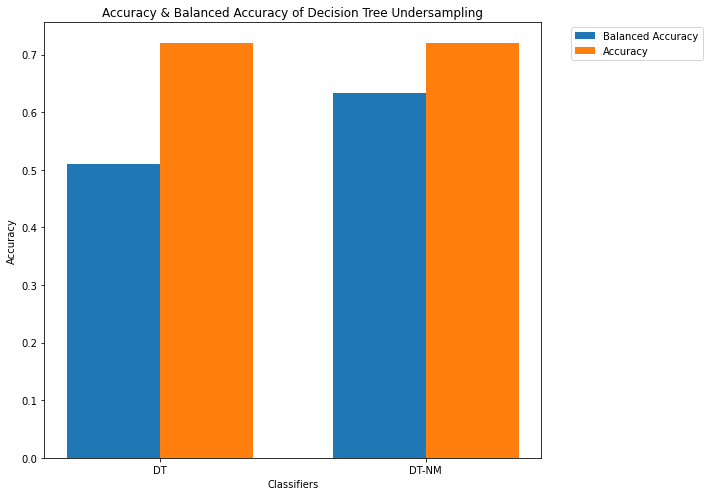

In [68]:
labels = ['DT','DT-NM',]
title= "Accuracy & Balanced Accuracy of Decision Tree Undersampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_nm=[model_scores['Balanced Accuracy'][1],dt_nm[1]]
dt_acc_nm=[model_scores['Accuracy'][1],dt_nm[0]]




grouped_plot(labels,dt_ba_nm,dt_acc_nm,title,label1,label2,x_label,y_label)

The improvement from applying the Near miss Can be seen in the growth in both Accuracy and Balanced Accuracy.

#### 2.2.1.3 Logistic Regression Near Miss 

In [69]:
lr_nm =classifier_info(X_resampled_nm1, X_test,y_resampled_nm1, y_test,logistic_reg,'GE5','L5')

nm_scores['NM Accuracy'].append(round(lr_nm[0],2))
nm_scores['NM Bal Acc'].append(round(lr_nm[1],2))

(144, 3) (123, 3)
Accuracy:  0.76
Balanced Accuracy: 0.68
Minority class in test set : 0.27
Predicted minority class : 0.23
Confusion matrix:
[[78 12]
 [17 16]]
Report:
              precision    recall  f1-score   support

         GE5       0.82      0.87      0.84        90
          L5       0.57      0.48      0.52        33

    accuracy                           0.76       123
   macro avg       0.70      0.68      0.68       123
weighted avg       0.75      0.76      0.76       123

Balanced Accuracy: 0.68
LogisticRegression: AUROC = 0.71


- The improvement from using Near Miss for imbalanced data is clear with the rise in both accuracy and Balanced accuracy from 0.74 to 0.76 and 0.55 to 0.68 respectively.

- The number of True postives has increased from 5 to 16

- The number of False negatives has dropped from 28 to 17.

- The minority class precision has improved from 0.56 to 0.57

- The minority class recall has improved from 0.15 to 0.48

- The AUROC increases to 0.71

- The positive  f1-score has increase to 0.52 and negative f1-scores has remained at 0.84.

- Near Miss When used with logistic appears to reduce the bias towards the minority class and increase the overall accuracy of the model.

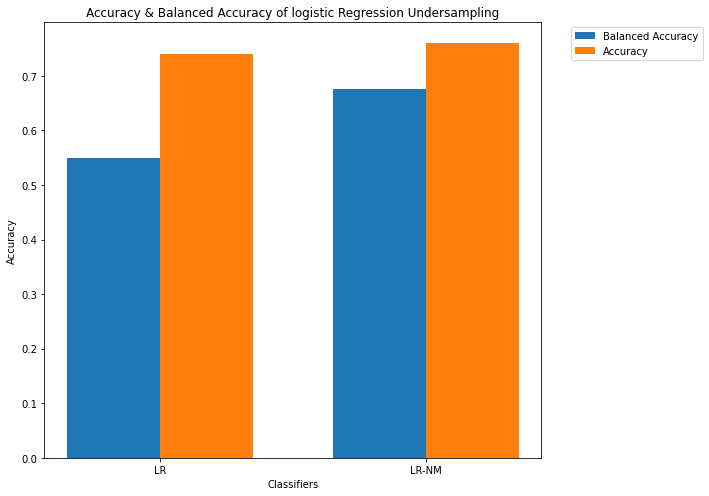

In [70]:
labels = ['LR','LR-NM',]
title= "Accuracy & Balanced Accuracy of logistic Regression Undersampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_nm=[model_scores['Balanced Accuracy'][2],lr_nm[1]]
lr_acc_nm=[model_scores['Accuracy'][2],lr_nm[0]]




grouped_plot(labels,lr_ba_nm,lr_acc_nm,title,label1,label2,x_label,y_label)

An improvement to Accuracy and Balanced Accuracy can be seen when using the Near miss technique.

#### 2.2.1.4 Gradient Boosting Near Miss 

In [71]:
gb_nm =classifier_info(X_resampled_nm1, X_test,y_resampled_nm1, y_test,grad_boost,'GE5','L5')


nm_scores['NM Accuracy'].append(round(gb_nm[0],2))
nm_scores['NM Bal Acc'].append(round(gb_nm[1],2))

(144, 3) (123, 3)
Accuracy:  0.67
Balanced Accuracy: 0.61
Minority class in test set : 0.27
Predicted minority class : 0.32
Confusion matrix:
[[67 23]
 [17 16]]
Report:
              precision    recall  f1-score   support

         GE5       0.80      0.74      0.77        90
          L5       0.41      0.48      0.44        33

    accuracy                           0.67       123
   macro avg       0.60      0.61      0.61       123
weighted avg       0.69      0.67      0.68       123

Balanced Accuracy: 0.61
GradientBoostingClassifier: AUROC = 0.68


- Both the Accuracy and Balanced accuracy have improved slightly over gradient without Near Miss, with 0.68 to 0.69 and 0.54 to 0.64 respectively. 

- The number of True Positives has increased from 8 to 17, while False Positive has fallen from 26 to 16.

- The Precision of the minority class has improved from 0.36 to 0.44

- The Recall of the minority class has improved from 0.24 to 0.52

- The AUROC has fallen from 0.85 to 0.69

- The f1-scores of the Negative class increased from 0.77 to 0.78 and the Positive class increase from 0.25 to 0.47 

- Overall, When Gradient Boosting is combined with Near Miss the improvement to bias towards minority class is great however,The trade off is a large fall in the True Negative predictions and a large increase in the False Positive predictions.

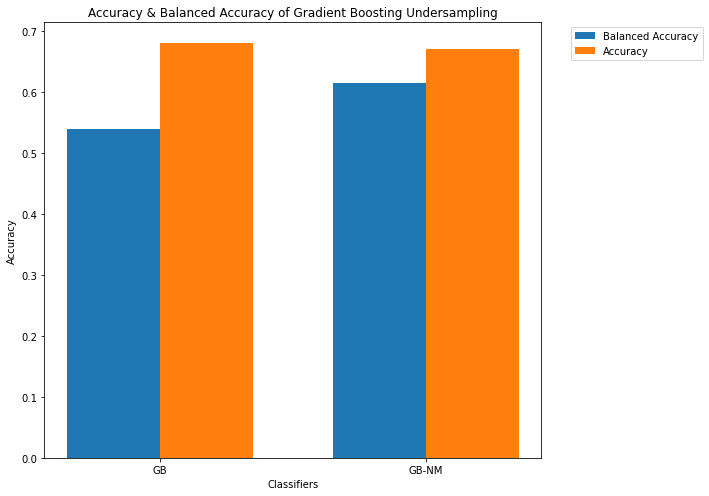

In [72]:
labels = ['GB','GB-NM',]
title= "Accuracy & Balanced Accuracy of Gradient Boosting Undersampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_nm=[model_scores['Balanced Accuracy'][3],gb_nm[1]]
gb_acc_nm=[model_scores['Accuracy'][3],gb_nm[0]]




grouped_plot(labels,gb_ba_nm,gb_acc_nm,title,label1,label2,x_label,y_label)

The improvements from applying the Near miss Can be seen in the growth in both Accuracy and Balanced Accuracy.

In [73]:
# Dsplay the accuracy and balanced accuracy
nm_scores_df = pd.DataFrame.from_dict(nm_scores)
nm_ba_ac = pd.concat([model_scores_df,nm_scores_df], axis=1)
nm_ba_ac = nm_ba_ac.loc[:,~nm_ba_ac.columns.duplicated()]
nm_ba_ac['Diff ACC'] = nm_ba_ac['NM Accuracy'] -nm_ba_ac['Accuracy']
nm_ba_ac['Diff BA'] = nm_ba_ac['NM Bal Acc'] - nm_ba_ac['Balanced Accuracy']
cols = nm_ba_ac.columns.tolist()
cols
cols=['Model',
 'Accuracy',
 'NM Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'NM Bal Acc',
 'Diff BA']

nm_ba_ac = nm_ba_ac[cols]
nm_ba_ac

,Model,Accuracy,NM Accuracy,Diff ACC,Balanced Accuracy,NM Bal Acc,Diff BA
0,kNN,0.76,0.72,-0.04,0.63,0.63,0.00
1,Decision Tree,0.72,0.72,0.00,0.51,0.63,0.12
2,Logistic Regression,0.74,0.76,0.02,0.55,0.68,0.13
3,Gradient Boosting,0.68,0.67,-0.01,0.54,0.61,0.07


- The table above shows a very slight improvement in accuracy for Logistic Regression and Gradient Boosting

- A fall in accuracy for kNN

- A growth in Balanced Accuracy for Decision tree,Logistic Regression and Gradient Boosting

### 2.2.2 Near Miss Analysis

Overall an improvement is seen when applying the Near Miss Undersampling technique to the four models in terms of  Balanced accuracy, precision, recall and f1-score. The level of improvement depended on the model used. 


The Logistic Regression model sees the  largest  reduction in bias towards the minority class with an improvement to both accuracy and balanced Accuracy. All Four models saw a reduction in bias towards the majority class with a large increase in both True Positive and False Positive predictions. The Precision of the models suffered as False Positive was estimated by each of the models more times than True Positive.

The Near Miss strategy is a good solution for a problem such as finding a Virus where it is safer to falsely predict a Positive test, however If both classes are of equal improtance it is not a suitable method. The Downside to This technique is that it can lead to a loss in information which is expensive to collect.

## 2.3 Oversampling
Oversampling is a technique which focuses on the minority class by repeating random examples from the minority class. This results in balancing the dataset. It may be referred to as up-sampling. The repetition of data may possibly lead to overfitting (Banerjee, 2020).

In [74]:
over_scores= {'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              'SMOTE Accuracy':[],       
              'ADASYN Accuracy':[],
              'SMOTE Balanced Accuracy':[],
              'ADASYN Balanced Accuracy':[],
    
}

### 2.3.1 SMOTE
Synthetic Minority Oversampling Technique (SMOTE) is a method used to generate examples from the minority class. Unlike in many oversampling techniques whereby data is duplicated but no new information is generated, SMOTE creates new data. It creates new synthetic data using the k-nearest neighbour algorithm (Wijaya, 2020).

In [75]:
X_over, y_over = SMOTE(k_neighbors=3,sampling_strategy=0.5,random_state=42).fit_resample(X_train, y_train)

print(sorted(Counter(y_over).items()))

[('GE5', 135), ('L5', 67)]


#### 2.3.1.1 KNN SMOTE

In [76]:
kNN_smote = classifier_info(X_over, X_test,y_over, y_test,kNN,'GE5','L5')

over_scores['SMOTE Accuracy'].append(round(kNN_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(kNN_smote[1],2))

(202, 3) (123, 3)
Accuracy:  0.74
Balanced Accuracy: 0.64
Minority class in test set : 0.27
Predicted minority class : 0.22
Confusion matrix:
[[77 13]
 [19 14]]
Report:
              precision    recall  f1-score   support

         GE5       0.80      0.86      0.83        90
          L5       0.52      0.42      0.47        33

    accuracy                           0.74       123
   macro avg       0.66      0.64      0.65       123
weighted avg       0.73      0.74      0.73       123

Balanced Accuracy: 0.64
KNeighborsClassifier: AUROC = 0.64


-  A drop in accuracy is seen from 0.76 to 0.74 while balanced Accuracy increases from 0.63 to 0.64

- The number of True postives has increased from 11 to 14

- The number of False negatives has dropped from 22 to 19.

- The minority class precision has fallen from 0.61 to 0.52

- The minority class recall has improved from 0.33 to 0.42

- The AUROC has fallen from 0.84 to 0.64

- The positive  f1-score increases from 0.43 to 0.47 and negative f1-scoresfalls from 0.85 to 0.83.

- SMOTE When used with KNN appears to greatly reduce the bias towards the minority class but reduce the precision when predicting True Positive.



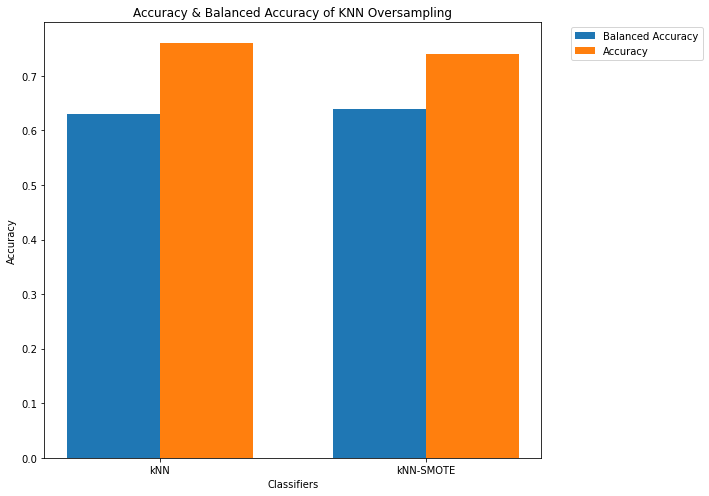

In [77]:
labels = ['kNN','kNN-SMOTE',]
title= "Accuracy & Balanced Accuracy of KNN Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_smote=[model_scores['Balanced Accuracy'][0],kNN_smote[1]]
kNN_acc_smote=[model_scores['Accuracy'][0],kNN_smote[0]]




grouped_plot(labels,kNN_ba_smote,kNN_acc_smote,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates the fall in accuracy and improvement to Balanced Accuracy.

#### 2.3.1.2 Decision Tree SMOTE

In [78]:
dt_smote = classifier_info(X_over, X_test,y_over, y_test,tree,'GE5','L5')

over_scores['SMOTE Accuracy'].append(round(dt_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(dt_smote[1],2))

(202, 3) (123, 3)
Accuracy:  0.75
Balanced Accuracy: 0.69
Minority class in test set : 0.27
Predicted minority class : 0.29
Confusion matrix:
[[73 17]
 [14 19]]
Report:
              precision    recall  f1-score   support

         GE5       0.84      0.81      0.82        90
          L5       0.53      0.58      0.55        33

    accuracy                           0.75       123
   macro avg       0.68      0.69      0.69       123
weighted avg       0.76      0.75      0.75       123

Balanced Accuracy: 0.69
DecisionTreeClassifier: AUROC = 0.69


- The improvement from using SMOTE for imbalanced data is clear with the large rise in both accuracy and Balanced accuracy from 0.72 to 0.75 and 0.63 to 0.79 respectively.

- The number of True postives has increased from 2 to 19

- The number of False negatives has dropped from 31 to 14.

- The minority class precision has improved from 0.33 to 0.53

- The minority class recall has improved from 0.06 to 0.58

- The AUROC has increased from 0.68 to 0.69

- The positive f1-score improved from 0.10 to 0.55 and negative f1-scores fell from 0.82 to 0.82.

- SMOTE When used with Decision Tree appears to greatly reduce the bias towards the minority class while increasing both the precision of the majority and minority class.


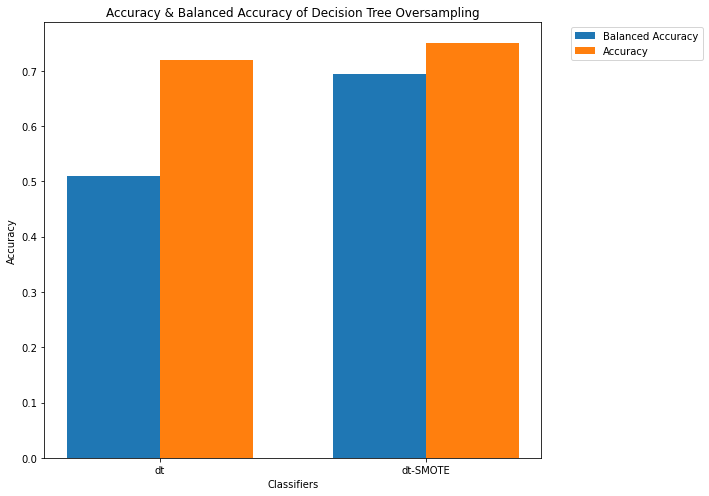

In [79]:
labels = ['dt','dt-SMOTE',]
title= "Accuracy & Balanced Accuracy of Decision Tree Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_smote=[model_scores['Balanced Accuracy'][1],dt_smote[1]]
dt_acc_smote=[model_scores['Accuracy'][1],dt_smote[0]]




grouped_plot(labels,dt_ba_smote,dt_acc_smote,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates clearly the improvement to both accuracy and Balanced Accuracy.

#### 2.3.1.3 Logistic Regression SMOTE

In [80]:
lr_smote = classifier_info(X_over, X_test,y_over, y_test,logistic_reg,'GE5','L5')

over_scores['SMOTE Accuracy'].append(round(lr_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(lr_smote[1],2))

(202, 3) (123, 3)
Accuracy:  0.77
Balanced Accuracy: 0.62
Minority class in test set : 0.27
Predicted minority class : 0.12
Confusion matrix:
[[85  5]
 [23 10]]
Report:
              precision    recall  f1-score   support

         GE5       0.79      0.94      0.86        90
          L5       0.67      0.30      0.42        33

    accuracy                           0.77       123
   macro avg       0.73      0.62      0.64       123
weighted avg       0.75      0.77      0.74       123

Balanced Accuracy: 0.62
LogisticRegression: AUROC = 0.68


- The improvement from using SMOTE for imbalanced data is clear with the rise in both accuracy and Balanced accuracy from 0.74 to 0.77 and 0.55 to 0.62 respectively.

- The number of True postives has increased from 5 to 10

- The number of False negatives has dropped from 28 to 23.

- The minority class precision has improved from 0.56 to 0.67

- The minority class recall has improved from 0.15 to 0.30

- The AUROC remains the same at 0.68

- The positive f1-score increased from 0.24 to 0.48 and negative f1-scores improved slightly from 0.84 to 0.86.

- SMOTE When used with logistic Regression appears to reduce the bias towards the minority class while improving the precision of both the majority and minority class.

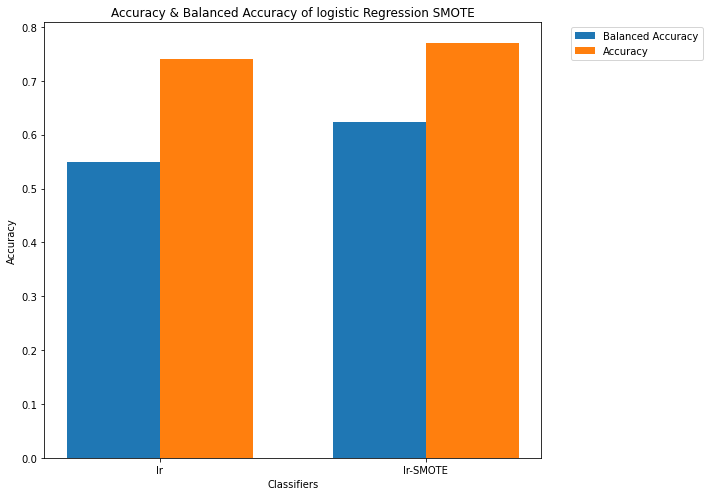

In [81]:
labels = ['lr','lr-SMOTE',]
title= "Accuracy & Balanced Accuracy of logistic Regression SMOTE"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_smote=[model_scores['Balanced Accuracy'][2],lr_smote[1]]
lr_acc_smote=[model_scores['Accuracy'][2],lr_smote[0]]




grouped_plot(labels,lr_ba_smote,lr_acc_smote,title,label1,label2,x_label,y_label)

The grouped barchart above shows the slight improvement SMOTE brings to Logistic Regression.

#### 2.3.1.4 Gradient Boosting SMOTE

In [82]:
gb_smote = classifier_info(X_over, X_test,y_over, y_test,grad_boost,'GE5','L5')

over_scores['SMOTE Accuracy'].append(round(gb_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(gb_smote[1],2))

(202, 3) (123, 3)
Accuracy:  0.67
Balanced Accuracy: 0.58
Minority class in test set : 0.27
Predicted minority class : 0.25
Confusion matrix:
[[71 19]
 [21 12]]
Report:
              precision    recall  f1-score   support

         GE5       0.77      0.79      0.78        90
          L5       0.39      0.36      0.38        33

    accuracy                           0.67       123
   macro avg       0.58      0.58      0.58       123
weighted avg       0.67      0.67      0.67       123

Balanced Accuracy: 0.58
GradientBoostingClassifier: AUROC = 0.64


- Both the Accuracy and Balanced accuracy have improved over kNN without SMOTE, with 0.65 to 0.68 and 0.54 to 0.58 respectively. 

- The number of True Positives has increased from 8 to 12, while False Positive has fallen from 26 to 21.

- The Precision of the minority class has improved from 0.36 to 0.97

- The Recall of the minority class has improved from 0.24 to 0.40

- The AUROC has fallen from 0.85 to 0.64

- The f1-scores of both the minority class has increased from 0.25 to 0.38 and majority classes have improved from 0.77 to 0.79.

- Overall, When Gradient Boosting is combined with SMOTE the improvement to bias towards minority class is great but failed to reduce the number of False Positive predictions.


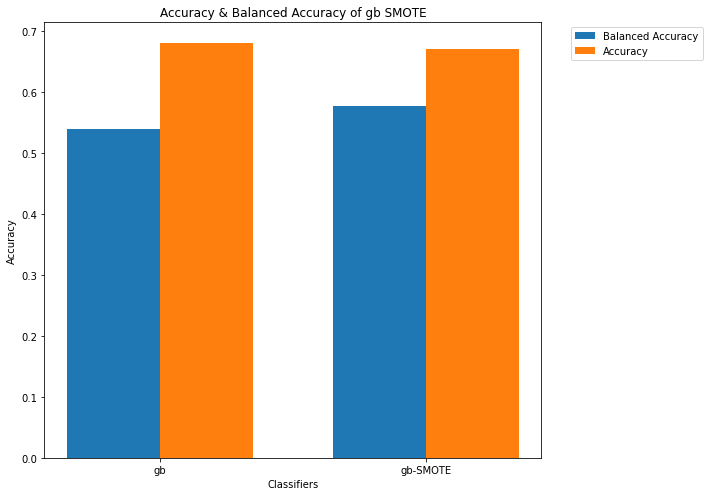

In [83]:
labels = ['gb','gb-SMOTE',]
title= "Accuracy & Balanced Accuracy of gb SMOTE"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_smote=[model_scores['Balanced Accuracy'][3],gb_smote[1]]
gb_acc_smote=[model_scores['Accuracy'][3],gb_smote[0]]




grouped_plot(labels,gb_ba_smote,gb_acc_smote,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates clearly the improvement to both accuracy and Balanced Accuracy.

#### 2.3.1.5 Evaluation of SMOTE
For all of the models tested an improvement was seen for all Balanced accuracy, precision, recall and f1-score. The Number of True Positives also increased. The effectiveness of the SMOTE technique varied greatly between models. kNN saw a reduction in accuracy and an increase in balanced accuracy.

The logistic Regression, Decision tree and Gradient Boosting models saw a reduction in their bias towards the majority class, and an increase in both accuracy and Balanced accuracy.

Overall SMOTE is an extremely effective way of reducing the bias in imbalanced data without losing any of the information.

### 2.3.2 ADASYN
Adaptive Synthetic (ADASYN) is an approach similar to SMOTE Where information is synthesised to create new information in imbalanced datasets. Samples from the minority class that are more difficult to learn are more likely to be used for the synthesizing process than those that are less difficult to learn. The benefit of the ADASYN approach is that it not only reduces classifier bias but also can aid in the process of classifying the samples that are close to the decision boundary (He et.al, 2008)

In [84]:
X_over_ADASYN, y_over_ADASYN = ADASYN(n_neighbors=3,sampling_strategy=0.5,random_state=42).fit_resample(X_train, y_train)
print(sorted(Counter(y_over).items()))

[('GE5', 135), ('L5', 67)]


#### 2.3.2.1 KNN ADASYN

In [85]:
kNN_ADASYN = classifier_info(X_over_ADASYN, X_test,y_over_ADASYN, y_test,kNN,'GE5','L5')

over_scores['ADASYN Accuracy'].append(round(kNN_ADASYN[0],2) )
over_scores['ADASYN Balanced Accuracy'].append(round(kNN_ADASYN[1],2))

(202, 3) (123, 3)
Accuracy:  0.72
Balanced Accuracy: 0.62
Minority class in test set : 0.27
Predicted minority class : 0.22
Confusion matrix:
[[76 14]
 [20 13]]
Report:
              precision    recall  f1-score   support

         GE5       0.79      0.84      0.82        90
          L5       0.48      0.39      0.43        33

    accuracy                           0.72       123
   macro avg       0.64      0.62      0.63       123
weighted avg       0.71      0.72      0.71       123

Balanced Accuracy: 0.62
KNeighborsClassifier: AUROC = 0.65


- when applying ADASYN, kNN saw a fall in accuracy from 0.76 to 0.72 and balanced accuracy from 0.63 to 0.62

- The number of True postives has increased from 11 to 13

- The number of False negatives has dropped from 22 to 20.

- The minority class precision has fallen from 0.61 to 0.48

- The minority class recall has improved from 0.33 to 0.39

- The AUROC has fallen from 0.84 to 0.65

- The positive f1-score remains at 0.43 and the negative f1-scores fell from 0.85 to 0.82.

- ADASYN When used with KNN appears to reduce the bias towards the minority class but leads to poorer preicion in predicting when predicting the minority class.


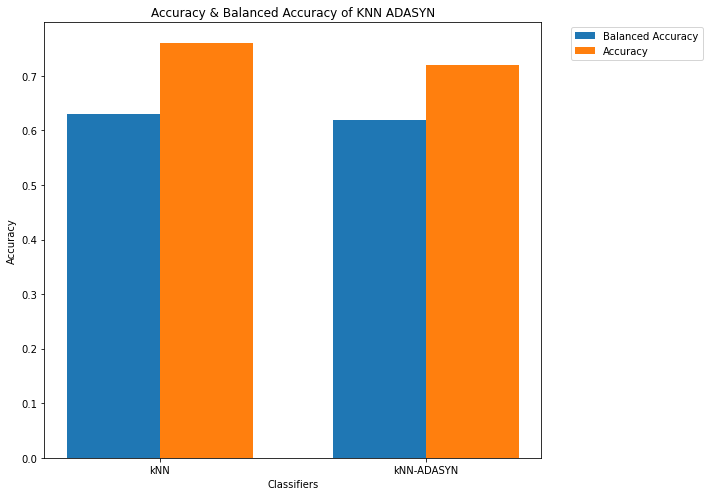

In [86]:
labels = ['kNN','kNN-ADASYN',]
title= "Accuracy & Balanced Accuracy of KNN ADASYN"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_ADASYN=[model_scores['Balanced Accuracy'][0],kNN_ADASYN[1]]
kNN_acc_ADASYN=[model_scores['Accuracy'][0],kNN_ADASYN[0]]




grouped_plot(labels,kNN_ba_ADASYN,kNN_acc_ADASYN,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates clearly the fall to both accuracy and Balanced Accuracy.

#### 2.3.2.1 Decision Tree ADASYN

In [87]:
dt_ADASYN = classifier_info(X_over_ADASYN, X_test,y_over_ADASYN, y_test,tree,'GE5','L5')

over_scores['ADASYN Accuracy'].append(round(dt_ADASYN[0],2) )
over_scores['ADASYN Balanced Accuracy'].append(round(dt_ADASYN[1],2 ))

(202, 3) (123, 3)
Accuracy:  0.74
Balanced Accuracy: 0.71
Minority class in test set : 0.27
Predicted minority class : 0.33
Confusion matrix:
[[70 20]
 [12 21]]
Report:
              precision    recall  f1-score   support

         GE5       0.85      0.78      0.81        90
          L5       0.51      0.64      0.57        33

    accuracy                           0.74       123
   macro avg       0.68      0.71      0.69       123
weighted avg       0.76      0.74      0.75       123

Balanced Accuracy: 0.71
DecisionTreeClassifier: AUROC = 0.72


- The improvement from using SMOTE for imbalanced data is clear with the rise in both accuracy and Balanced accuracy from 0.72 to 0.74 and 0.63 to 0.71 respectively.

- The number of True postives has increased from 2 to 21

- The number of False negatives has dropped from 31 to 12.

- The minority class precision has improved from 0.33 to 0.51

- The minority class recall has improved from 0.06 to 0.64

- The AUROC has fallen from 0.75 to 0.72

- The positive  f1-score increased from 0.10 to 0.57 and negative f1-scores fell from 0.83 to 0.85.

- ADASYN When used with Decision Tree appears to greatly reduce the bias towards the minority class with an improvement to the overall precision but a large increas in the False positive predictions.

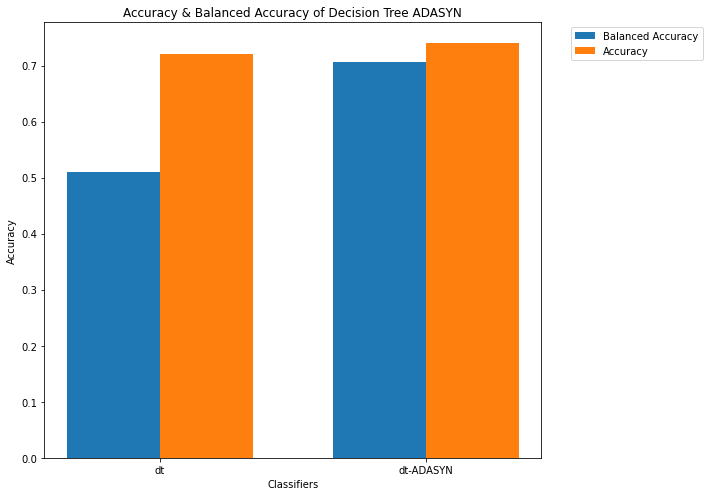

In [88]:
labels = ['dt','dt-ADASYN',]
title= "Accuracy & Balanced Accuracy of Decision Tree ADASYN"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_ADASYN=[model_scores['Balanced Accuracy'][1],dt_ADASYN[1]]
dt_acc_ADASYN=[model_scores['Accuracy'][1],dt_ADASYN[0]]




grouped_plot(labels,dt_ba_ADASYN,dt_acc_ADASYN,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates clearly the improvement to both accuracy and Balanced Accuracy.

#### 2.3.2.3 Logistic Regression ADASYN

In [89]:
lr_ADASYN = classifier_info(X_over_ADASYN, X_test,y_over_ADASYN, y_test,logistic_reg,'GE5','L5')

over_scores['ADASYN Accuracy'].append(round(lr_ADASYN[0],2))
over_scores['ADASYN Balanced Accuracy'].append(round(lr_ADASYN[1],2))

(202, 3) (123, 3)
Accuracy:  0.75
Balanced Accuracy: 0.58
Minority class in test set : 0.27
Predicted minority class : 0.10
Confusion matrix:
[[85  5]
 [26  7]]
Report:
              precision    recall  f1-score   support

         GE5       0.77      0.94      0.85        90
          L5       0.58      0.21      0.31        33

    accuracy                           0.75       123
   macro avg       0.67      0.58      0.58       123
weighted avg       0.72      0.75      0.70       123

Balanced Accuracy: 0.58
LogisticRegression: AUROC = 0.67


- The improvement from using SMOTE for imbalanced data is clear with the rise in both accuracy and Balanced accuracy from 0.74 to 0.75 and 0.55 to 0.58 respectively.

- The number of True postives has increased from 5 to 7

- The number of False negatives has dropped from 28 to 26.

- The minority class precision has improved from 0.56 to 0.68.

- The minority class recall has improved from 0.15 to 0.21

- The AUROC has fallen from 0.68 to 0.67

- The positive f1-score increased from 0.24 to 0.31  and negative f1-scores improved form 0.84 to 0.85.

- ADASYN When used with logistic appears to slightly reduce the bias towards the minority class.

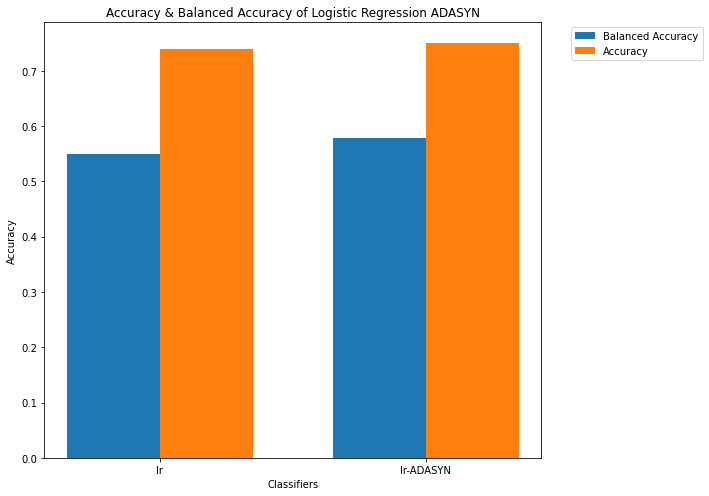

In [90]:
labels = ['lr','lr-ADASYN',]
title= "Accuracy & Balanced Accuracy of Logistic Regression ADASYN"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_ADASYN=[model_scores['Balanced Accuracy'][2],lr_ADASYN[1]]
lr_acc_ADASYN=[model_scores['Accuracy'][2],lr_ADASYN[0]]




grouped_plot(labels,lr_ba_ADASYN,lr_acc_ADASYN,title,label1,label2,x_label,y_label)

The grouped barchart above shows the slight improvement ADASYN brings to Logistic Regression.

#### 2.3.2.4 Gradient Boosting ADASYN

In [91]:
gb_ADASYN = classifier_info(X_over_ADASYN, X_test,y_over_ADASYN, y_test,grad_boost,'GE5','L5')

over_scores['ADASYN Accuracy'].append(round(gb_ADASYN[0],2))
over_scores['ADASYN Balanced Accuracy'].append(round(gb_ADASYN[1],2))

(202, 3) (123, 3)
Accuracy:  0.68
Balanced Accuracy: 0.59
Minority class in test set : 0.27
Predicted minority class : 0.26
Confusion matrix:
[[71 19]
 [20 13]]
Report:
              precision    recall  f1-score   support

         GE5       0.78      0.79      0.78        90
          L5       0.41      0.39      0.40        33

    accuracy                           0.68       123
   macro avg       0.59      0.59      0.59       123
weighted avg       0.68      0.68      0.68       123

Balanced Accuracy: 0.59
GradientBoostingClassifier: AUROC = 0.62


- Both the Accuracy and Balanced accuracy have improved over kNN without ADASYN, with 0.65 to 0.67 and 0.54 to 0.57 respectively. 

- The number of True Positives has increased from 8 to 12, while False Positive has fallen from 26 to 21.

- The Precision of the minority class has improved from 0.36 to 0.38

- The Recall of the minority class has improved from 0.24 to 0.36

- The AUROC has fallen from 0.85 to 0.62

- The f1-scores of the minority class increased from 0.25 to 0.37 and majority classes remains the same at 0.77.

- Overall, When Gradient Boosting is combined with ADASYN the improvement to bias towards minority class is great however there is a larger number of False Negative predictions than True Positive.


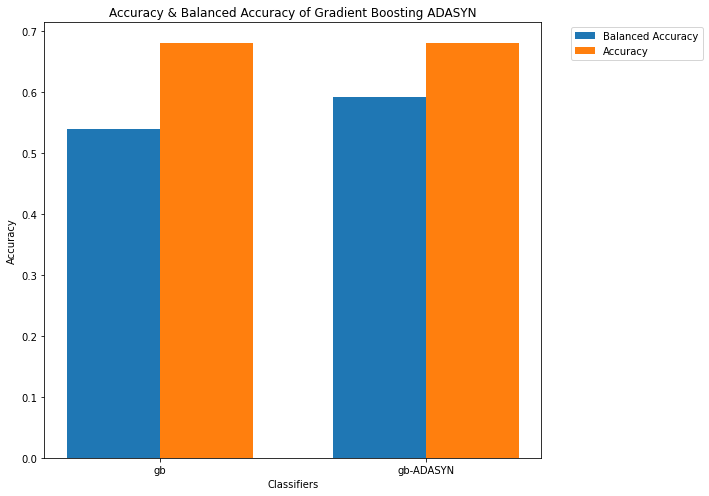

In [92]:
labels = ['gb','gb-ADASYN',]
title= "Accuracy & Balanced Accuracy of Gradient Boosting ADASYN"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_ADASYN=[model_scores['Balanced Accuracy'][3],gb_ADASYN[1]]
gb_acc_ADASYN=[model_scores['Accuracy'][3],gb_ADASYN[0]]




grouped_plot(labels,gb_ba_ADASYN,gb_acc_ADASYN,title,label1,label2,x_label,y_label)

The grouped barchart demonstrates clearly the improvement to both accuracy and Balanced Accuracy.

#### 2.3.2.4 Evaluation of ADASYN
The results for ADASYN  were very similar to that of SMOTE with both oversampling methods improving the precision, recall and f1-score for all four models.  Although it saw an increase in the minority class being predicted the kNN model saw a fal in both Accuracy and Balanced Accuracy.  The other three models saw an improvement to both Accuracy and Balanced Accuracy.

Overall ADASYN is an extremely effective way of reducing the bias in imbalanced data without losing any of the information.

In [93]:
over_df = pd.DataFrame.from_dict(over_scores)
over_df

,Model,SMOTE Accuracy,ADASYN Accuracy,SMOTE Balanced Accuracy,ADASYN Balanced Accuracy
0,kNN,0.74,0.72,0.64,0.62
1,Decision Tree,0.75,0.74,0.69,0.71
2,Logistic Regression,0.77,0.75,0.62,0.58
3,Gradient Boosting,0.67,0.68,0.58,0.59


In [94]:
smote_df = over_df[['Model','SMOTE Accuracy','SMOTE Balanced Accuracy']]
smote_df = pd.concat([model_scores_df,smote_df], axis=1)
smote_df = smote_df.loc[:,~smote_df.columns.duplicated()]

smote_df['Diff ACC'] = smote_df['SMOTE Accuracy'] -smote_df['Accuracy']
smote_df['Diff BA'] = smote_df['SMOTE Balanced Accuracy'] - smote_df['Balanced Accuracy']

cols = smote_df.columns.tolist()
cols= ['Model',
 'Accuracy',
 'SMOTE Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'SMOTE Balanced Accuracy',
 'Diff BA']

smote_df = smote_df[cols]
smote_df

,Model,Accuracy,SMOTE Accuracy,Diff ACC,Balanced Accuracy,SMOTE Balanced Accuracy,Diff BA
0,kNN,0.76,0.74,-0.02,0.63,0.64,0.01
1,Decision Tree,0.72,0.75,0.03,0.51,0.69,0.18
2,Logistic Regression,0.74,0.77,0.03,0.55,0.62,0.07
3,Gradient Boosting,0.68,0.67,-0.01,0.54,0.58,0.04


- The table above shows that aside from kNN the accuracy of all the models has improved slightly

- All of the models saw an improvement  in Balanced Accuracy when the SMOTE technique was used with, the decision tree showing the largest improvement. 

In [95]:
adasyn_df = over_df[['Model','ADASYN Accuracy','ADASYN Balanced Accuracy']]
adasyn_df = pd.concat([model_scores_df,adasyn_df], axis=1)
adasyn_df = adasyn_df.loc[:,~adasyn_df.columns.duplicated()]

adasyn_df['Diff ACC'] = adasyn_df['ADASYN Accuracy'] -adasyn_df['Accuracy']
adasyn_df['Diff BA'] = adasyn_df['ADASYN Balanced Accuracy'] - adasyn_df['Balanced Accuracy']

cols = adasyn_df.columns.tolist()
cols= ['Model',
 'Accuracy',
 'ADASYN Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'ADASYN Balanced Accuracy',
 'Diff BA']

adasyn_df = adasyn_df[cols]
adasyn_df

,Model,Accuracy,ADASYN Accuracy,Diff ACC,Balanced Accuracy,ADASYN Balanced Accuracy,Diff BA
0,kNN,0.76,0.72,-0.04,0.63,0.62,-0.01
1,Decision Tree,0.72,0.74,0.02,0.51,0.71,0.20
2,Logistic Regression,0.74,0.75,0.01,0.55,0.58,0.03
3,Gradient Boosting,0.68,0.68,0.00,0.54,0.59,0.05


- The table above shows that aside from kNN the accuracy of all the models has improved slightly

- Apart from kNN all the models saw an improvement  in Balanced Accuracy when the SMOTE technique was used with, the decision tree showing the largest improvement. 

### 2.3.3 Evaluation of Oversampling
There is very little difference evident between the two oversampling techniques. Both techniques greatly reduced the bias towards the majority class seen by the large increase in the number of predictions of the true positive and True Negative class.
In both techniques the kNN model saw a decrease in the accuracy, however, the SMOTE technique improved the kNN Balanced Accuracy while the ADASYN technique reduced the Balanced Accuracy.

Whe looking at the table above it is clear that apart from the Balanced Accuracy for the Decision Tree model the SMOTE technique provides the  larger improvement to both Accuracy and Balanced Accuracy.



## 2.4 Evaluating Strategies

In [96]:
bag_ba_ac

,Model,Accuracy,Bagging Accuracy,Diff ACC,Balanced Accuracy,Bagging Bal Acc,Diff BA
0,kNN,0.76,0.80,0.04,0.63,0.67,0.04
1,Decision Tree,0.72,0.76,0.04,0.51,63.00,62.49
2,Logistic Regression,0.74,0.75,0.01,0.55,0.58,0.03
3,Gradient Boosting,0.68,0.75,0.07,0.54,0.58,0.04


In [97]:
nm_ba_ac

,Model,Accuracy,NM Accuracy,Diff ACC,Balanced Accuracy,NM Bal Acc,Diff BA
0,kNN,0.76,0.72,-0.04,0.63,0.63,0.00
1,Decision Tree,0.72,0.72,0.00,0.51,0.63,0.12
2,Logistic Regression,0.74,0.76,0.02,0.55,0.68,0.13
3,Gradient Boosting,0.68,0.67,-0.01,0.54,0.61,0.07


In [98]:
smote_df

,Model,Accuracy,SMOTE Accuracy,Diff ACC,Balanced Accuracy,SMOTE Balanced Accuracy,Diff BA
0,kNN,0.76,0.74,-0.02,0.63,0.64,0.01
1,Decision Tree,0.72,0.75,0.03,0.51,0.69,0.18
2,Logistic Regression,0.74,0.77,0.03,0.55,0.62,0.07
3,Gradient Boosting,0.68,0.67,-0.01,0.54,0.58,0.04


In [99]:
adasyn_df

,Model,Accuracy,ADASYN Accuracy,Diff ACC,Balanced Accuracy,ADASYN Balanced Accuracy,Diff BA
0,kNN,0.76,0.72,-0.04,0.63,0.62,-0.01
1,Decision Tree,0.72,0.74,0.02,0.51,0.71,0.20
2,Logistic Regression,0.74,0.75,0.01,0.55,0.58,0.03
3,Gradient Boosting,0.68,0.68,0.00,0.54,0.59,0.05


In [100]:
mean_scores= {'Technique':['Bagging','Near Miss','SMOTE','ADASYN'],
              'Mean Accuracy':[
                  bag_ba_ac['Diff ACC'].mean(),
                    nm_ba_ac['Diff ACC'].mean(),
                    smote_df['Diff ACC'].mean(),
                    adasyn_df['Diff ACC'].mean()
              ],
              'Mean Balanced Accuracy':[
                  bag_ba_ac['Diff BA'].mean(),
                    nm_ba_ac['Diff BA'].mean(),
                    smote_df['Diff BA'].mean(),
                    adasyn_df['Diff BA'].mean()
              ]
    
}

mean_df = pd.DataFrame.from_dict(mean_scores)
mean_df['Average'] = mean_df[['Mean Accuracy', 'Mean Balanced Accuracy']].mean(axis=1)
mean_df

,Technique,Mean Accuracy,Mean Balanced Accuracy,Average
0,Bagging,0.0400,15.6500,7.84500
1,Near Miss,-0.0075,0.0800,0.03625
2,SMOTE,0.0075,0.0750,0.04125
3,ADASYN,-0.0025,0.0675,0.03250


When assessing the quality of each of the strategies undertaken in part 2 no one technique stands out above the rest when it comes to its impact on the accuracy and Balanced accuracy. Each of the techniques achieve its goal of reducing the bias towards the minority class, with a large number of both True Positive and False positive predictions. 

- When looking at the table above the Bagging technique lead to the largest improvement in accuracy, with Gradient boosting seeing the largest increase.


- The Near miss strategy saw the largest improvement when it comes to Balanced accuracy. Though this strategy was poor for the kNN classifier


- ADASYN saw the no improvement on average to the accuracy of each of the classifiers. 


- The kNN classifier when paired with Bagging achieved the highest accuracy of 0.80 an improvement from 0.76, it also achieved a relatively decent Balanced accuracy of 0.67 an increase from 0.63


- The classifier that achieved the highest Balanced accuracy was the Decision tree when used with ADASYN an increase from 0.51 to 0.71.


- If all models were required to be used then the technique that provides the best average of Mean Accuracy and Mean Balanced Accuracy would be the Bagging technique.


- By looking at the Average table of  Accuracy and Balanced Accuracy all four models are extremely close with ADASYN performing worst overall.

When considering which of the strategies worked best a trade-off between Accuracy, Balanced accuracy, and a reduction in Bias towards the majority class all must be considered.

One factor that could be considered when conducting further research on imbalance data is parameter tuning of each classifier, and rectifying strategy. This may involve reducing or increasing the size of the resampled Oversampling and Undersampling data. Test should be conducted to assess which of the three versions of the near miss strategy yields the best results, depending on which classifier is used.


## 2.5 Results of Analysis
As Bagging was the most successful of all strategies assessed in the section, it will be used as a strategy for rectifying the bias towards the majority class in a new imbalanced dataset. Both Near miss and SMOTE were equal but due to the benefit of SMOTE not losing any information when the data is resampled unlike Near Miss it too will be used on the new dataset.

# Part 3 Trialing Strategy for Rectifying Bias

A similar process will be undertaken as above but the new dataset will only be tested using the Bagginga and SMOTE techniques. 

In [101]:
diabetes = pd.read_csv('pima-indians-diabetes.csv',header=None)
diabetes.head()

,0,1,2,3,4,5,6,7,8
0,10,161,68,23,132,25.5,0.326,47,1
1,0,128,68,19,180,30.5,1.391,25,1
2,2,124,68,28,205,32.9,0.875,30,1
3,2,155,74,17,96,26.6,0.433,27,1
4,7,109,80,31,0,35.9,1.127,43,1


In [102]:
diabetes[8].value_counts() 

0    498
1    151
Name: 8, dtype: int64

In [103]:
y = diabetes.pop(8).values
ap_features = diabetes.columns
X = diabetes.values
X.shape, y.shape

((649, 8), (649,))

In [104]:
print("Minority class : %0.2f" % (Counter(y)[1]/len(y)))

Minority class : 0.23


In [105]:
# Dictionary to store models scores
new_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'Accuracy':[],
              'Balanced Accuracy':[]
              
             }

## 3.1 Train Test Split

In [106]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)

## 3.2 kNN

In [107]:
kNN_new = classifier_info(X_train, X_test, y_train, y_test,kNN,0,1)

new_scores['Accuracy'].append(kNN_new[0])
new_scores['Balanced Accuracy'].append(round(kNN_new[1],2))


(389, 8) (260, 8)
Accuracy:  0.77
Balanced Accuracy: 0.65
Minority class in test set : 0.27
Predicted minority class : 0.17
Confusion matrix:
[[173  18]
 [ 42  27]]
Report:
              precision    recall  f1-score   support

           0       0.80      0.91      0.85       191
           1       0.60      0.39      0.47        69

    accuracy                           0.77       260
   macro avg       0.70      0.65      0.66       260
weighted avg       0.75      0.77      0.75       260

Balanced Accuracy: 0.65
KNeighborsClassifier: AUROC = 0.71


- The minority class is predicted only 0.17 out of the actual 0.27

- The False Negative is higher than the True Positive at 42 compared to 27

- The Precision for the minority class is 0.60 whereas the majority class precision is 0.80

- The Recall for the minority class is 0.39 whereas the majority class precision is 0.90

- The f1-score for the minority class is 0.47 whereas the majority class precision is 0.85

- The Accuracy of 0.77 is higher than the Balanced Accuracy at 0.65

- The poorer Precision recall and f1-score for the minority class and the larger number of False Negatives than True Positives suggests that there is a bias in the classifier towards predicting the majority class.


## 3.3 Decision Tree

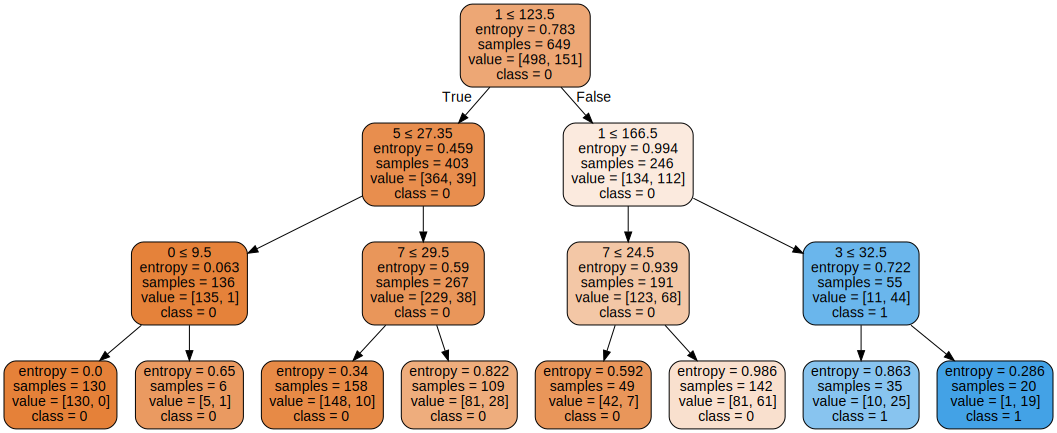

In [108]:
ap_tree = tree.fit(X, y)
tree_ap = export_graphviz(ap_tree, out_file=None, 
                      feature_names=ap_features,
                      class_names=['0','1'],  
                      filled=True, rounded=True,  
                      special_characters=True)  
graph = Source(tree_ap)  
graph

In [109]:
dt_new = classifier_info(X_train, X_test, y_train, y_test,tree,0,1)

new_scores['Accuracy'].append(dt_new[0])
new_scores['Balanced Accuracy'].append(round(dt_new[1],2))

(389, 8) (260, 8)
Accuracy:  0.78
Balanced Accuracy: 0.68
Minority class in test set : 0.27
Predicted minority class : 0.21
Confusion matrix:
[[169  22]
 [ 36  33]]
Report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       191
           1       0.60      0.48      0.53        69

    accuracy                           0.78       260
   macro avg       0.71      0.68      0.69       260
weighted avg       0.76      0.78      0.77       260

Balanced Accuracy: 0.68
DecisionTreeClassifier: AUROC = 0.71


- The minority class is predicted only 0.21 out of the actual 0.27

- The False Negative is higher than the True Positive at 36 compared to 33

- The Precision for the minority class is 0.60 whereas the majority class precision is 0.82

- The Recall for the minority class is 0.48 whereas the majority class precision is 0.88

- The f1-score for the minority class is 0.53 whereas the majority class precision is 0.85

- The Accuracy of 0.78 is higher than the Balanced Accuracy at 0.68

- The poorer Precision recall and f1-score for the minority class and the larger number of False Negatives than True Positives suggests that there is a bias in the classifier towards predicting the majority class.


## 3.3 Logistic Regresion

In [110]:
lr_new = classifier_info(X_train, X_test, y_train, y_test,logistic_reg,0,1)

new_scores['Accuracy'].append(lr_new[0])
new_scores['Balanced Accuracy'].append(round(lr_new[1],2))

(389, 8) (260, 8)
Accuracy:  0.79
Balanced Accuracy: 0.67
Minority class in test set : 0.27
Predicted minority class : 0.16
Confusion matrix:
[[178  13]
 [ 41  28]]
Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       191
           1       0.68      0.41      0.51        69

    accuracy                           0.79       260
   macro avg       0.75      0.67      0.69       260
weighted avg       0.78      0.79      0.77       260

Balanced Accuracy: 0.67
LogisticRegression: AUROC = 0.82


- The minority class is predicted only 0.16 out of the actual 0.27

- The False Negative is higher than the True Positive at 41 compared to 28

- The Precision for the minority class is 0.68 whereas the majority class precision is 0.81

- The Recall for the minority class is 0.41 whereas the majority class precision is 0.93

- The f1-score for the minority class is 0.51 whereas the majority class precision is 0.87

- The Accuracy of 0.79 is higher than the Balanced Accuracy at 0.67

- The poorer Precision recall and f1-score for the minority class and the larger number of False Negatives than True Positives suggests that there is a bias in the classifier towards predicting the majority class.


## 3.4 Gradient Boosting

In [111]:
gb_new = classifier_info(X_train, X_test, y_train, y_test,grad_boost,0,1)

new_scores['Accuracy'].append(gb_new[0])
new_scores['Balanced Accuracy'].append(round(gb_new[1],2))

(389, 8) (260, 8)
Accuracy:  0.77
Balanced Accuracy: 0.65
Minority class in test set : 0.27
Predicted minority class : 0.17
Confusion matrix:
[[174  17]
 [ 42  27]]
Report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86       191
           1       0.61      0.39      0.48        69

    accuracy                           0.77       260
   macro avg       0.71      0.65      0.67       260
weighted avg       0.75      0.77      0.75       260

Balanced Accuracy: 0.65
GradientBoostingClassifier: AUROC = 0.81


- The minority class is predicted only 0.17 out of the actual 0.27

- The False Negative is higher than the True Positive at 42 compared to 27

- The Precision for the minority class is 0.60 whereas the majority class precision is 0.80

- The Recall for the minority class is 0.39 whereas the majority class precision is 0.91

- The f1-score for the minority class is 0.47 whereas the majority class precision is 0.85

- The Accuracy of 0.77 is higher than the Balanced Accuracy at 0.65

- The poorer Precision recall and f1-score for the minority class and the larger number of False Negatives than True Positives suggests that there is a bias in the classifier towards predicting the majority class.


## 3.5 Evaluation of Models
It is clear to see that for each of the models there is a bias in predicting the majority class, evident from the larger number of predictions of the False Negative class. The Balanced accuracy of each of the classifiers is much lower than the accuracy. The precision recall and f1-scores are all significantly lower for the minority class than the majority class.

In [112]:
new_scores_df = pd.DataFrame.from_dict(new_scores)
new_scores_df

,Model,Accuracy,Balanced Accuracy
0,kNN,0.77,0.65
1,Decision Tree,0.78,0.68
2,Logistic Regression,0.79,0.67
3,Gradient Boosting,0.77,0.65


## 3.6 Applying Strategies to Rectify Bias

### 3.6.1 SMOTE

In [113]:
X_over, y_over = SMOTE(k_neighbors=3,sampling_strategy=0.5,random_state=42).fit_resample(X_train, y_train)

print(sorted(Counter(y_over).items()))

[(0, 307), (1, 153)]


In [114]:
over_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'SMOTE Accuracy':[],
              'SMOTE Balanced Accuracy':[]
              
             }

#### 3.6.1.1 KNN SMOTE

In [115]:
kNN_smote = classifier_info(X_over, X_test,y_over, y_test,kNN,0,1)

over_scores['SMOTE Accuracy'].append(round(kNN_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(kNN_smote[1],2))

(460, 8) (260, 8)
Accuracy:  0.76
Balanced Accuracy: 0.69
Minority class in test set : 0.27
Predicted minority class : 0.27
Confusion matrix:
[[160  31]
 [ 31  38]]
Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       191
           1       0.55      0.55      0.55        69

    accuracy                           0.76       260
   macro avg       0.69      0.69      0.69       260
weighted avg       0.76      0.76      0.76       260

Balanced Accuracy: 0.69
KNeighborsClassifier: AUROC = 0.72


- The Accuracy of KNN falls from 0.77 to 0.76 while Balanced Accuracy improves from 0.65 to 0.69

- The number of True postives has increased from 27 to 31

- The number of False negatives has dropped from 42 to 31.

- The minority class precision has fallen from 0.60 to 0.55

- The minority class recall has improved from 0.39 to 0.55

- The AUROC has increased from 0.71 to 0.72

- The positive f1-score has increased from 0.47 to 0.55 and negative f1-scores fell from 0.85 to 0.84.

- SMOTE When used with KNN appears to greatly reduce the bias towards the minority class but the precision of the minority class falls.



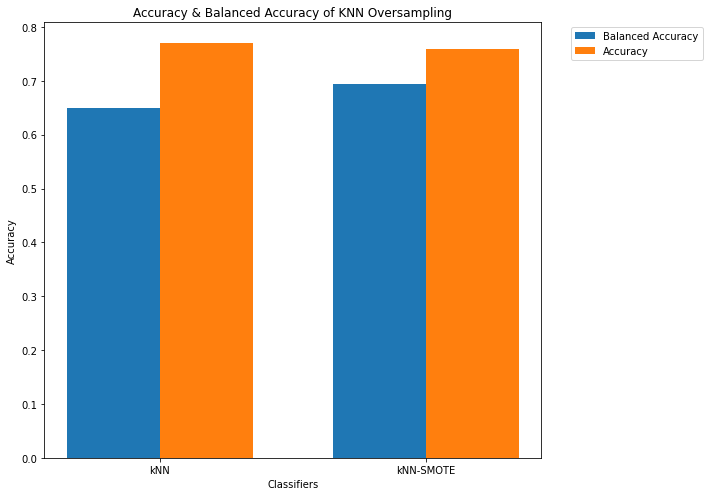

In [116]:
labels = ['kNN','kNN-SMOTE',]
title= "Accuracy & Balanced Accuracy of KNN Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_smote=[new_scores['Balanced Accuracy'][0],kNN_smote[1]]
kNN_acc_smote=[new_scores['Accuracy'][0],kNN_smote[0]]




grouped_plot(labels,kNN_ba_smote,kNN_acc_smote,title,label1,label2,x_label,y_label)

The slight fall in accuracy and improvement to Balanced Accuracy can be seen in the grouped barchart above.

#### 3.6.1.2  Decison Tree SMOTE

In [117]:
dt_smote = classifier_info(X_over, X_test,y_over, y_test,tree,0,1)


over_scores['SMOTE Accuracy'].append(round(dt_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(dt_smote[1],2))

(460, 8) (260, 8)
Accuracy:  0.75
Balanced Accuracy: 0.67
Minority class in test set : 0.27
Predicted minority class : 0.23
Confusion matrix:
[[163  28]
 [ 36  33]]
Report:
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       191
           1       0.54      0.48      0.51        69

    accuracy                           0.75       260
   macro avg       0.68      0.67      0.67       260
weighted avg       0.75      0.75      0.75       260

Balanced Accuracy: 0.67
DecisionTreeClassifier: AUROC = 0.79


- Accuracy fell from 0.78 to 0.75

- Balanced accuracy fell from 0.68 to 0.67 .

- The number of True postives remains the same

- The number of False positive rises from 22 top 28

- The number of False negatives remains at from 36.

- The minority class precision has fallen from 0.60 to 0.54

- The minority class remains at 0.48 

- The Negative f1-score has fallen from 0.85 to 0.84

- The positive f1-score  increase from 0.53 to  0.61.

- The AUROC has increased from 0.71 to 0.79

- SMOTE When used with Decision Tree appears to greatly reduce the bias towards the minority class however this lead to a large number of false Positive predictions while the False Negatives does not change.

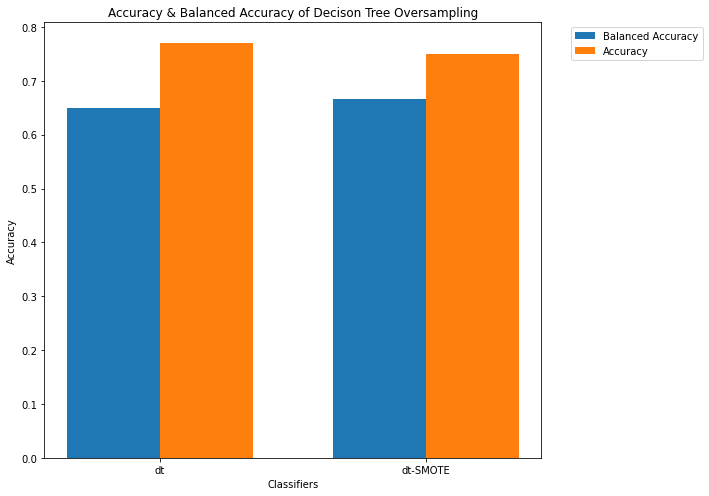

In [118]:
labels = ['dt','dt-SMOTE',]
title= "Accuracy & Balanced Accuracy of Decison Tree Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_smote=[new_scores['Balanced Accuracy'][0],dt_smote[1]]
dt_acc_smote=[new_scores['Accuracy'][0],dt_smote[0]]




grouped_plot(labels,dt_ba_smote,dt_acc_smote,title,label1,label2,x_label,y_label)

The grouped Barchart above shows the slight fall in both accuracy and Balanced Accuracy

#### 3.6.1.3  Logistic Regression SMOTE

In [119]:
lr_smote = classifier_info(X_over, X_test,y_over, y_test,logistic_reg,0,1)


over_scores['SMOTE Accuracy'].append(round(lr_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(lr_smote[1],2))

(460, 8) (260, 8)
Accuracy:  0.77
Balanced Accuracy: 0.71
Minority class in test set : 0.27
Predicted minority class : 0.26
Confusion matrix:
[[162  29]
 [ 30  39]]
Report:
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       191
           1       0.57      0.57      0.57        69

    accuracy                           0.77       260
   macro avg       0.71      0.71      0.71       260
weighted avg       0.77      0.77      0.77       260

Balanced Accuracy: 0.71
LogisticRegression: AUROC = 0.81


- A fall in accuracy from 0.79 to 0.77 can be seen using SMOTE 

- Balanced accuracy improved from 0.67 to 0.71.

- The number of True postives has increased from 28 to 39.

- The number of False negatives has dropped from 41 to 30.

- The minority class precision has fallen from 0.68 to 0.57

- The minority class recall has improved from 0.41 to 0.57

- The AUROC has fallen from 0.82 to 0.81

- SMOTE When used with Logistic Regression appears to reduce the bias towards the minority class but the precision becomes poorer as the number of False Positives increases drastically .

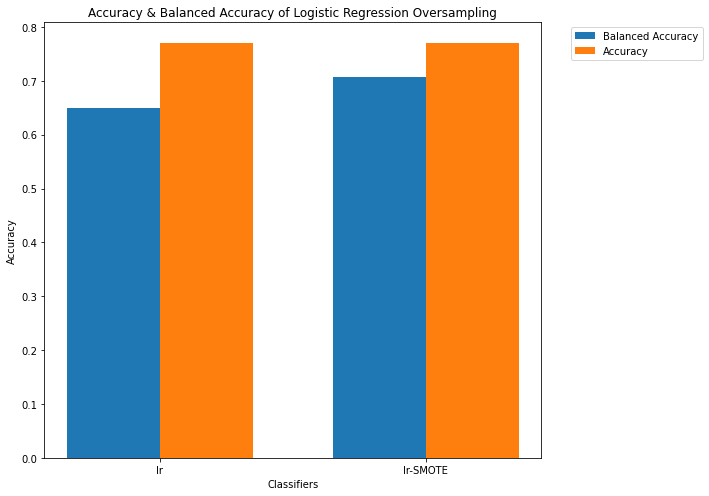

In [120]:
labels = ['lr','lr-SMOTE',]
title= "Accuracy & Balanced Accuracy of Logistic Regression Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_smote=[new_scores['Balanced Accuracy'][0],lr_smote[1]]
lr_acc_smote=[new_scores['Accuracy'][0],lr_smote[0]]




grouped_plot(labels,lr_ba_smote,lr_acc_smote,title,label1,label2,x_label,y_label)

The small increase in Balanced accuracy and drop in accuracy can be seen in the grouped barchart above.

#### 3.6.1.4  Gradient Boost SMOTE

In [121]:
gb_smote = classifier_info(X_over, X_test,y_over, y_test,grad_boost,0,1)


over_scores['SMOTE Accuracy'].append(round(gb_smote[0],2))
over_scores['SMOTE Balanced Accuracy'].append(round(gb_smote[1],2))

(460, 8) (260, 8)
Accuracy:  0.77
Balanced Accuracy: 0.68
Minority class in test set : 0.27
Predicted minority class : 0.23
Confusion matrix:
[[166  25]
 [ 35  34]]
Report:
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       191
           1       0.58      0.49      0.53        69

    accuracy                           0.77       260
   macro avg       0.70      0.68      0.69       260
weighted avg       0.76      0.77      0.76       260

Balanced Accuracy: 0.68
GradientBoostingClassifier: AUROC = 0.81


- Accuracy remains at 0.77 when using SMOTE 

- Balanced accuracy improved from 0.66 to 0.68.

- The number of True postives has increased from 28 to 34.

- The number of False negatives has dropped from 41 to 30.

- The minority class precision has fallen from 0.68 to 0.59

- The minority class recall has improved from 0.41 to 0.49

- The AUROC remains at 0.81

- SMOTE When used with Gradient Boosting appears to reduce the bias towards the minority class but the precision becomes poorer as the number of False Positives increases.

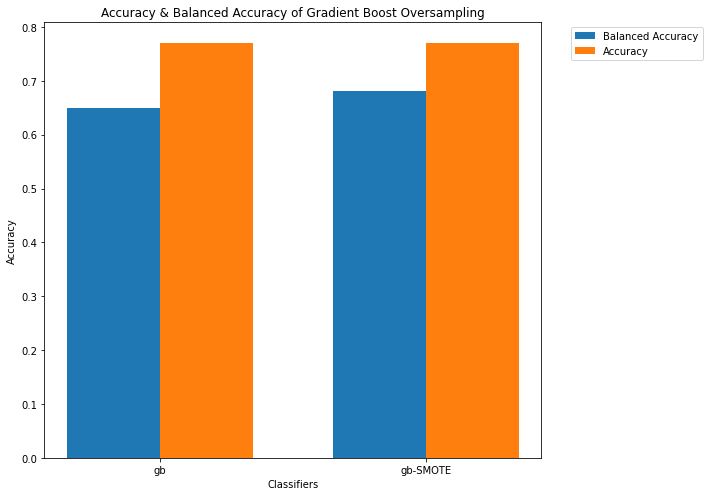

In [122]:
labels = ['gb','gb-SMOTE',]
title= "Accuracy & Balanced Accuracy of Gradient Boost Oversampling"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_smote=[new_scores['Balanced Accuracy'][0],gb_smote[1]]
gb_acc_smote=[new_scores['Accuracy'][0],gb_smote[0]]




grouped_plot(labels,gb_ba_smote,gb_acc_smote,title,label1,label2,x_label,y_label)

The grouped Barchart above shows the small improvement to Balanced accuracy when SMOTE is used

In [123]:
over_df = pd.DataFrame.from_dict(over_scores)


smote_df = pd.concat([new_scores_df,over_df], axis=1)
smote_df = smote_df.loc[:,~smote_df.columns.duplicated()]
smote_df


smote_df['Diff ACC'] = smote_df['SMOTE Accuracy'] -smote_df['Accuracy']
smote_df['Diff BA'] = smote_df['SMOTE Balanced Accuracy'] - smote_df['Balanced Accuracy']

cols = smote_df.columns.tolist()
cols= ['Model',
 'Accuracy',
 'SMOTE Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'SMOTE Balanced Accuracy',
 'Diff BA']

smote_df = smote_df[cols]
smote_df

,Model,Accuracy,SMOTE Accuracy,Diff ACC,Balanced Accuracy,SMOTE Balanced Accuracy,Diff BA
0,kNN,0.77,0.76,-0.01,0.65,0.69,0.04
1,Decision Tree,0.78,0.75,-0.03,0.68,0.67,-0.01
2,Logistic Regression,0.79,0.77,-0.02,0.67,0.71,0.04
3,Gradient Boosting,0.77,0.77,0.00,0.65,0.68,0.03


- When looking at the table above The accuracy for all of the models falls when the SMOTE technique is applied

- For all of the Models except Decision tree a small improvement to Balanced accuracy is seen.

- A small reduction in bias towards the majority class is evident from the Fall in False Negatives and increas in True Positives

- This reduction in bias towards the majority class has improved the Minority class precision slightly Though the number of False Positives have also increased.

#### 3.6.1.5 Evaluation of  SMOTE Strategy

The results of this strategy for the new imbalanced dataset are extremely mixed. When looking at the kNN and Gradient Boosting classifiers it appears to be extremely successful, with an increase in both Accuracy and Balanced Accuracy. On the other hand, the Decision Tree and Logistic Regression classifiers accuracies decreased marginally, although the bias towards the majority class decreased
 However, both classifiers precision was poorer than before the data was resampled. 
The strategy achieved its goal of reducing the bias towards the majority class.


### 3.6.2 Bagging

In [124]:
bag_scores={'Model':[
                        'kNN',
                        'Decision Tree',
                        'Logistic Regression',
                        'Gradient Boosting'
                    ],
              
              'Bagging Accuracy':[],
              'Bagging Bal Acc':[]
              
             }

#### 3.6.2.1 kNN Bagging

In [125]:
kNN_bag_setup = BaggingClassifier(base_estimator=kNN, n_estimators=100,bootstrap=True,random_state=42)

kNN_bag =classifier_info(X_train, X_test,y_train, y_test,kNN_bag_setup,0,1)


bag_scores['Bagging Accuracy'].append(round(kNN_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(kNN_bag[1],2))

(389, 8) (260, 8)
Accuracy:  0.79
Balanced Accuracy: 0.68
Minority class in test set : 0.27
Predicted minority class : 0.18
Confusion matrix:
[[175  16]
 [ 39  30]]
Report:
              precision    recall  f1-score   support

           0       0.82      0.92      0.86       191
           1       0.65      0.43      0.52        69

    accuracy                           0.79       260
   macro avg       0.73      0.68      0.69       260
weighted avg       0.77      0.79      0.77       260

Balanced Accuracy: 0.68
BaggingClassifier: AUROC = 0.76


- The accuracy of the kNN classifier when used with Bagging improves from 0.77 to 0.79, While the balanced accuracy improves from 0.65 to 0.68.

- The number of True Positive predictions increases from 27 to 30 While the False Positives falls from 18 to 16. Overall, the percentage of minority class predicted remains at 0.18 of 0.27.

- Precision of the Positive class improves from 0.61 to 0.65

- Recall of the Positive class improves from 0.33 to 0.43

- The f1-score of the Positive class increases from 0.47 to 0.52 and the Negative class improves from 0.85 to 0.86.

- The AUROC has increases from 0.71 to 0.76

- Bagging using kNN appears to be a good solution to deal with the bias towards the majority class as increases the f1-score,accuracy and Balanced accuracy of the kNN classifier.

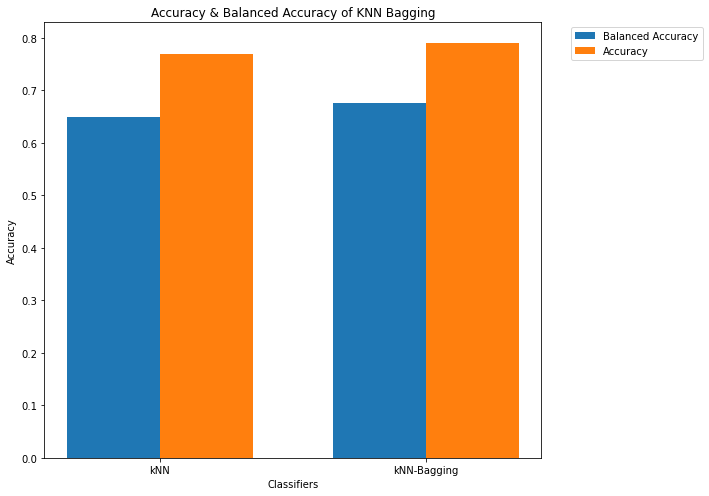

In [126]:
labels = ['kNN','kNN-Bagging',]
title= "Accuracy & Balanced Accuracy of KNN Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



kNN_ba_list=[new_scores['Balanced Accuracy'][0],kNN_bag[1]]
kNN_acc_list=[new_scores['Accuracy'][0],kNN_bag[0]]




grouped_plot(labels,kNN_ba_list,kNN_acc_list,title,label1,label2,x_label,y_label)

The above grouped barchart shows the improvement to both accuracy and balanced accuracy when Bagging is used.

#### 3.6.2.2 Decision Tree Bagging

In [127]:
dt_bag_setup = BaggingClassifier(base_estimator=tree, n_estimators=100,bootstrap=True,random_state=42)

dt_bag =classifier_info(X_train, X_test,y_train, y_test,dt_bag_setup,0,1)

bag_scores['Bagging Accuracy'].append(round(dt_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(dt_bag[1],2))

(389, 8) (260, 8)
Accuracy:  0.80
Balanced Accuracy: 0.66
Minority class in test set : 0.27
Predicted minority class : 0.13
Confusion matrix:
[[182   9]
 [ 44  25]]
Report:
              precision    recall  f1-score   support

           0       0.81      0.95      0.87       191
           1       0.74      0.36      0.49        69

    accuracy                           0.80       260
   macro avg       0.77      0.66      0.68       260
weighted avg       0.79      0.80      0.77       260

Balanced Accuracy: 0.66
BaggingClassifier: AUROC = 0.83


- The Accuracy of the Decision tree classifier when used with bagging improved from 0.72 to 0.80 however the balanced accuracy falls from 0.68 to 0.66.

- The True positive predictions falls from 33 to 25 while the number of false positive predictions falls from 22 to 9.


- The precision for the minority class improved from 0.60 to 0.74 .


- The recall for the minority class falls from 0.36 to 0.25.


- The AUROC has increased from 0.71 to 0.83


- The f1-score for the minority class fell from 0.53 to 0.49, while the majority class increased from 0.85 to 0.87


- When Bagging is used with The Decision tree there is an overall increase in the bias towards the majority class with a drop in both False and True Positive predictions.

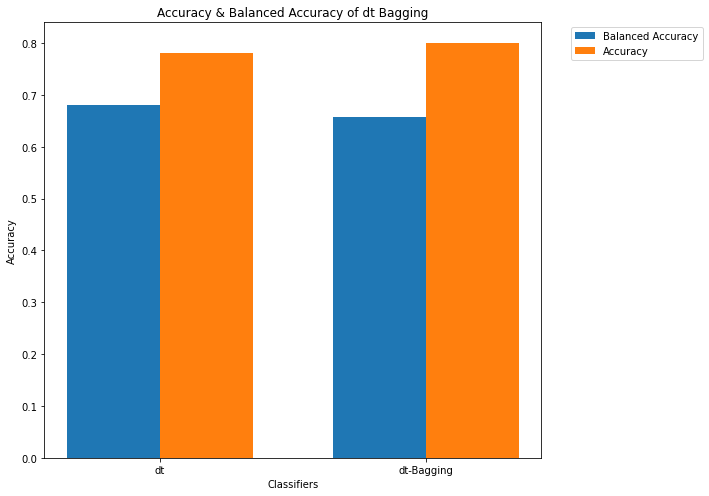

In [128]:
labels = ['dt','dt-Bagging',]
title= "Accuracy & Balanced Accuracy of dt Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



dt_ba_list=[new_scores['Balanced Accuracy'][1],dt_bag[1]]
dt_acc_list=[new_scores['Accuracy'][1],dt_bag[0]]




grouped_plot(labels,dt_ba_list,dt_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate the small improvement in accuracy and fall  in balanced accuracy for the Decision tree classifier.

#### 3.6.2.3 Logistic Regression Bagging

In [129]:
lr_bag_setup = BaggingClassifier(base_estimator=logistic_reg, n_estimators=100,bootstrap=True,random_state=42)

lr_bag =classifier_info(X_train, X_test,y_train, y_test,lr_bag_setup,0,1)

bag_scores['Bagging Accuracy'].append(round(lr_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(lr_bag[1],2))

(389, 8) (260, 8)
Accuracy:  0.79
Balanced Accuracy: 0.67
Minority class in test set : 0.27
Predicted minority class : 0.16
Confusion matrix:
[[177  14]
 [ 41  28]]
Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       191
           1       0.67      0.41      0.50        69

    accuracy                           0.79       260
   macro avg       0.74      0.67      0.69       260
weighted avg       0.77      0.79      0.77       260

Balanced Accuracy: 0.67
BaggingClassifier: AUROC = 0.82


- The Accuracy and Balanced of the model remain the same at 0.79 and 0.67 respectively.

- The number of True positives remains at 28 while the number of False Positives increases from 13 to 14.

- The AUROC has remained the same at 0.82

- The Precision of the minority class falls from 0.68 to 0.67

- The f1 scores for the positive class falls from 0.51 to 0.50  while the Negative class remains at 0.87

- The results of the Bagging test suggest that no real reduction in bias towards the majority class is seen.

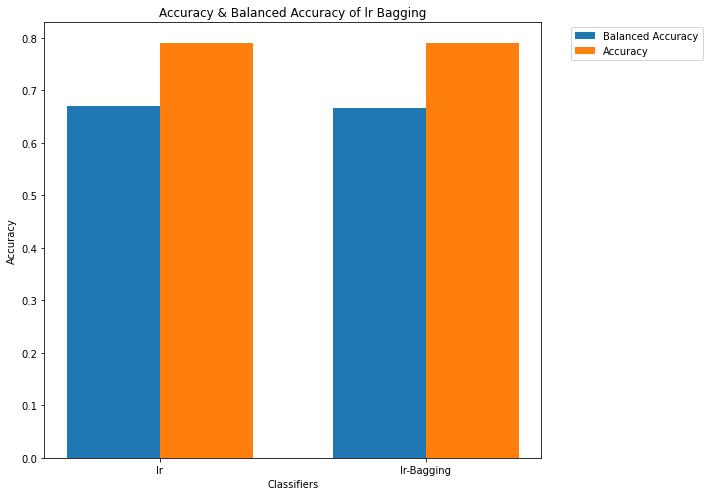

In [130]:
labels = ['lr','lr-Bagging',]
title= "Accuracy & Balanced Accuracy of lr Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



lr_ba_list=[new_scores['Balanced Accuracy'][2],lr_bag[1]]
lr_acc_list=[new_scores['Accuracy'][2],lr_bag[0]]




grouped_plot(labels,lr_ba_list,lr_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate that no real change is seen when Bagging is used with Logistic Regression.

#### 3.6.2.4 Gradient Boosting Bagging

In [131]:
gb_bag_setup = BaggingClassifier(base_estimator=logistic_reg, n_estimators=100,bootstrap=True,random_state=42)

gb_bag =classifier_info(X_train, X_test,y_train, y_test,gb_bag_setup,0,1)

bag_scores['Bagging Accuracy'].append(round(gb_bag[0],2))
bag_scores['Bagging Bal Acc'].append(round(gb_bag[1],2))

(389, 8) (260, 8)
Accuracy:  0.79
Balanced Accuracy: 0.67
Minority class in test set : 0.27
Predicted minority class : 0.16
Confusion matrix:
[[177  14]
 [ 41  28]]
Report:
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       191
           1       0.67      0.41      0.50        69

    accuracy                           0.79       260
   macro avg       0.74      0.67      0.69       260
weighted avg       0.77      0.79      0.77       260

Balanced Accuracy: 0.67
BaggingClassifier: AUROC = 0.82


- When used with Bagging The Gradient boosting models sees a slight improvement in accuracy from 0.77 to 0.79 and balanced accuracy from 0.66 to 0.67.

- The precision at predicting the negative class has remained at 28.

- The f1-score for the positive class inceases from 0.49 to 0.50  and the Negative class increases from 0.85 to 0.87

- The AUROC has increases from 0.81 to 0.82

- The Bagging method does not appear to improve the bias towards the majority class with fewer predictions for the minority class but improves the number of True Negative predictions.

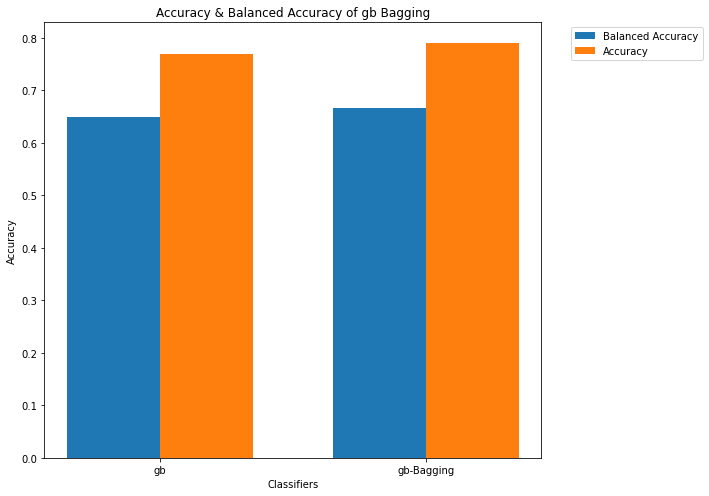

In [132]:
labels = ['gb','gb-Bagging',]
title= "Accuracy & Balanced Accuracy of gb Bagging"
label1 = "Balanced Accuracy"
label2 = "Accuracy"
x_label = "Classifiers"
y_label = "Accuracy"
size = (8,5)



gb_ba_list=[new_scores['Balanced Accuracy'][3],gb_bag[1]]
gb_acc_list=[new_scores['Accuracy'][3],gb_bag[0]]




grouped_plot(labels,gb_ba_list,gb_acc_list,title,label1,label2,x_label,y_label)

The Grouped barchart above demsonstrate the small improvement in balanced accuracy  accuracy for the Gradient Boost classifier.

In [133]:
bag_scores_df = pd.DataFrame.from_dict(bag_scores)
bag_scores_df

,Model,Bagging Accuracy,Bagging Bal Acc
0,kNN,0.79,0.68
1,Decision Tree,0.80,0.66
2,Logistic Regression,0.79,0.67
3,Gradient Boosting,0.79,0.67


In [134]:
# Dsplay the accuracy and balanced accuracy
bag_scores_df = pd.DataFrame.from_dict(bag_scores)
bag_ba_ac = pd.concat([new_scores_df,bag_scores_df], axis=1)
bag_ba_ac = bag_ba_ac.loc[:,~bag_ba_ac.columns.duplicated()]


bag_ba_ac['Diff ACC'] = bag_ba_ac['Bagging Accuracy'] -bag_ba_ac['Accuracy']
bag_ba_ac['Diff BA'] = bag_ba_ac['Bagging Bal Acc'] - bag_ba_ac['Balanced Accuracy']

cols = bag_ba_ac.columns.tolist()
cols
cols=['Model',
 'Accuracy',
 'Bagging Accuracy',
 'Diff ACC',
 'Balanced Accuracy',
 'Bagging Bal Acc',
 'Diff BA']


bag_ba_ac = bag_ba_ac[cols]
bag_ba_ac

,Model,Accuracy,Bagging Accuracy,Diff ACC,Balanced Accuracy,Bagging Bal Acc,Diff BA
0,kNN,0.77,0.79,0.02,0.65,0.68,0.03
1,Decision Tree,0.78,0.80,0.02,0.68,0.66,-0.02
2,Logistic Regression,0.79,0.79,0.00,0.67,0.67,0.00
3,Gradient Boosting,0.77,0.79,0.02,0.65,0.67,0.02


#### 3.6.2.5 Evaluation of Bagging
Overall the Bagging approach sees only a small reduction in the The bias towards the Majority class. For this dataset it does not apperar to be a suitable solution for dealing with imbalanced datasets.

Apart from the kNN classifier the Bagging technique does not appear to reduce the bias towards the majority class. This is evident from the number of True Positive and False Positive predictions not increases and often falling.

## 3.7 Evaluation of Strategy
When observing the results of Section three, it is clear that a solution that works well with one data set, may not always work well with another. This was the case with the technique of bagging when using the original survival data set. This technique saw a reduction in bias towards the majority class with an increase in both false and true positive predictions. It also saw both accuracy and balanced accuracy improvements.

Whereas the bagging technique when applied to the new dataset saw a similar increase in both accuracy and balanced accuracy but did not see the same reduction in bias towards the majority class. This was seen as the improvement in accuracy, were as a result of the better predictions of the majority class.

When looking at applying this SMOTE technique to deal with the imbalance data, the results of section two were extremely positive, with most of the models seeing a small increase in accuracy and a larger increase in Balanced Accuracy. This went with the increase in predictions of both the true positive and false positive classes.
When the SMOTE technique was applied to the new imbalanced data set the model saw a fall in the accuracy and a very small increase in balanced accuracy. However, when looking at the confusion matrices for the four models there was a clear reduction in bias towards the majority class as false negatives fell, while false positives and true positives increased.

Of the two strategies, applied, even though it was not reflected in either of the Accuracies or Balanced  Accuracies, the SMOTE technique was more successful,  as this assignment focuses on the reduction in classifier bias towards the majority class and not on the accuracy of the model.

###### References
- Banerjee, P. (2020). pb111/Data-Preprocessing-Project-Imbalanced-Classes-Problem. [online] GitHub. Available at: https://github.com/pb111/Data-Preprocessing-Project-Imbalanced-Classes-Problem [Accessed 9 Oct. 2020].


- Brownlee, J. (2020a). Undersampling Algorithms For Imbalanced Classification. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/> [Accessed 12 October 2020].



- Brownlee, J. (2020b). ROC Curves and Precision-Recall Curves for Imbalanced Classification. [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/.




- GeeksforGeeks. (2019). ML | Handling Imbalanced Data with SMOTE and Near Miss Algorithm in Python. [online] Available at: https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/.



- Scikit-learn.org. (2010). sklearn.metrics.balanced_accuracy_score — scikit-learn 0.21.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html.


- Scikit-learn.org. (2012). 1.11. Ensemble methods — scikit-learn 0.22.1 documentation. [online] Available at: https://scikit-learn.org/stable/modules/ensemble.html [Accessed 9 Oct. 2020].


- Scikit-learn.org. (2019). 3.2.4.3.1. sklearn.ensemble.RandomForestClassifier — scikit-learn 0.21.3 documentation. [online] Available at: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier [Accessed 9 Oct. 2020].



-  Wijaya, C.W.  (2020). 5 SMOTE Techniques For Oversampling Your Imbalance Data. [online] Available at: <https://towardsdatascience.com/5-smote-techniques-for-oversampling-your-imbalance-data-b8155bdbe2b5> [Accessed 12 October 2020].


-  He, H.  Bai Y.  Garcia E. A. and  Li S,(2008) "ADASYN: Adaptive synthetic sampling approach for imbalanced learning," 2008 IEEE International Joint Conference on Neural Networks (IEEE World Congress on Computational Intelligence), Hong Kong, 2008, pp. 1322-1328, doi: 10.1109/IJCNN.2008.4633969.